# Aplicação de Séries Temporais

Discentes:
- Adriele Correia Ribeiro
- Gisele Cerqueira Conceição
- Victor Miranda Bulhosa

Docente:
- Renato Novais

Disciplina:
- PPGESP-ESPA04-6: Análise Visual de Dados

Título do Artigo:
- Uma Análise Visual do Cenário de Realização de Mamografias na Bahia

Índice:  
1.  Introdução  
2.  Análise Exploratória de dados - EDA  
  2.1 Pré-Processamento de Dados  
  2.2 Transformações de Atributos  
  2.3 Dados faltantes  
  2.4 Análise Univariada  
  2.5 Decomposição da Série Temporal  
  2.6 Teste Estacionário  
  2.7 Técnica para tornar a série temporal estacionária  
    2.7.1 Diferenciação da série  
    2.7.2 Transformação Boxcox  
  2.8 Autocorrelação  
3. Modelagem  
  3.1 Divisão em conjunto de treino e teste  
  3.2 Comparando modelos  
  3.3 Gerando previsões  
4. Resultados

## 1. Introdução

Este trabalho tem por objetivo realizar uma análise visual da detecção precoce do câncer de mama nos municípios Bahia, avaliando o histórico dos últimos anos (2017 a 2023) e apresentando uma estimativa do cenário futuro (2024 e 2025) por meio das referências do manual de parâmetros técnicos do INCA e pela aplicação aplicação da análise de séries
temporais

As bases de dados utilizadas foram adquiridas através do site do DataSUS e do IBGE, e contêm:
- Quantidade de exames realizados na Bahia por mês (janeiro/2017 a setembro/2023) por tipo de resultado;
- Quantidade de exames realizados por município baiano e por mês (janeiro/2017 a setembro/2023);
- Quantidade de exames diagnosticados como lesão de câncer por município baiano e por mês (março/2017 a setembro/2023);
- Cidades e Mesorregiões da Bahia.



In [ ]:
# !pip install pmdarima
!pip install odfpy

In [ ]:
# Análise de dados e construção de gráficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import datetime

# Decomposição de série temporal
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Teste estacionário
from statsmodels.tsa.stattools import adfuller, kpss

# Plotar gráficos de autocorrelação
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Transformação BoxCox
from scipy import stats
from scipy.special import inv_boxcox

# Método de comparação entre os modelos - RMSE
from sklearn.metrics import mean_squared_error

# Bloquear warnings
import warnings
warnings.filterwarnings('ignore')

# Modelo PROPHET
from prophet import Prophet

In [ ]:
# Dataset de Resultados de Exames de Mamografia:
df_resultados_exames = pd.read_csv('mamografia_residba16984970756.csv', sep = ';', decimal = ',', encoding = 'latin')
df_resultados_exames

,Mes/Ano competenc,Normais,Alterados,Não visualizados,Ignorado,Total
0,JANEIRO/2017,4398,331,2315,36,7080
1,FEVEREIRO/2017,4343,119,2505,38,7005
2,MARÇO/2017,6336,191,3504,59,10090
3,ABRIL/2017,6005,57,3863,69,9994
4,MAIO/2017,8458,13,5236,75,13782
...,...,...,...,...,...,...
78,JULHO/2023,16505,170,8672,216,25563
79,AGOSTO/2023,19035,161,9983,283,29462
80,SETEMBRO/2023,16727,125,7525,183,24560
81,Ignorado,191065,11413,102540,1293,306311


In [ ]:
# Dataset de Total de Exames por Cidade e Mês/Ano:
df_exames_cidades = pd.read_csv('mamografia_residba16987182839.csv', sep = ';', decimal = ',', encoding = 'latin')
df_exames_cidades

,Munic.de residencia,JANEIRO/2017,FEVEREIRO/2017,MARÇO/2017,ABRIL/2017,MAIO/2017,JUNHO/2017,JULHO/2017,AGOSTO/2017,SETEMBRO/2017,...,JANEIRO/2023,FEVEREIRO/2023,MARÇO/2023,ABRIL/2023,MAIO/2023,JUNHO/2023,JULHO/2023,AGOSTO/2023,SETEMBRO/2023,Total
0,290010 ABAIRA,0,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,1,629
1,290020 ABARE,0,0,0,1,7,0,5,8,6,...,1,0,22,2,34,4,3,2,10,1792
2,290030 ACAJUTIBA,1,0,0,0,1,4,2,3,9,...,3,4,4,6,6,4,6,19,13,1458
3,290035 ADUSTINA,0,0,32,114,26,13,2,1,0,...,20,3,9,4,14,4,13,12,7,2150
4,290040 AGUA FRIA,1,0,6,9,12,11,31,23,19,...,14,9,12,12,8,42,38,52,14,1918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,293340 WAGNER,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,2,1,513
414,293345 WANDERLEY,0,1,1,1,0,1,4,0,4,...,9,15,12,9,11,2,6,6,9,1596
415,293350 WENCESLAU GUIMARAES,0,1,1,0,2,9,15,7,2,...,10,24,1089,19,4,6,5,2,5,1567
416,293360 XIQUE-XIQUE,1,0,0,3,4,7,9,6,6,...,6,1,3,4,2,1,2,4,2,3266


In [ ]:
# Dataset de Quantidade de Lesões de Câncer por Cidade e Mês/Ano:
df_lesoes_cancer = pd.read_csv('mamografia_residba16988818099.csv', sep = ';', decimal = ',', encoding = 'latin')
df_lesoes_cancer

,Munic.de residencia,MARÇO/2017,ABRIL/2017,MAIO/2017,JUNHO/2017,JULHO/2017,AGOSTO/2017,SETEMBRO/2017,OUTUBRO/2017,NOVEMBRO/2017,...,FEVEREIRO/2023,MARÇO/2023,ABRIL/2023,MAIO/2023,JUNHO/2023,JULHO/2023,AGOSTO/2023,SETEMBRO/2023,Ignorado,Total
0,290010 ABAIRA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,290070 ALAGOINHAS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,290080 ALCOBACA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,290090 ALMADINA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,290100 AMARGOSA,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,293315 VARZEA NOVA,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
182,293320 VERA CRUZ,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
183,293345 WANDERLEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
184,293350 WENCESLAU GUIMARAES,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,4


In [ ]:
# Dataset Macrorregiões:
df_macrorregioes = pd.read_excel('regioes_geograficas_composicao_por_municipios_2017_20180911.ods', engine='odf')
df_macrorregioes

,nome_mun,CD_GEOCODI,cod_rgi,nome_rgi,cod_rgint,nome_rgint
0,Itapuã do Oeste,1101104,110001,Porto Velho,1101,Porto Velho
1,Candeias do Jamari,1100809,110001,Porto Velho,1101,Porto Velho
2,Nova Mamoré,1100338,110001,Porto Velho,1101,Porto Velho
3,Porto Velho,1100205,110001,Porto Velho,1101,Porto Velho
4,Guajará-Mirim,1100106,110001,Porto Velho,1101,Porto Velho
...,...,...,...,...,...,...
5565,Flores de Goiás,5207907,520022,Flores de Goiás,5206,Luziânia - Águas Lindas de Goiás
5566,Cavalcante,5205307,520022,Flores de Goiás,5206,Luziânia - Águas Lindas de Goiás
5567,Alto Paraíso de Goiás,5200605,520022,Flores de Goiás,5206,Luziânia - Águas Lindas de Goiás
5568,Água Fria de Goiás,5200175,520022,Flores de Goiás,5206,Luziânia - Águas Lindas de Goiás


## 2. Análise Exploratória dos Dados - EDA

---



### 2.1 Pré-processamento de Dados

In [ ]:
mapa_mes_data = {
    'JANEIRO': 1,
    'FEVEREIRO': 2,
    'MARÇO': 3,
    'ABRIL': 4,
    'MAIO': 5,
    'JUNHO': 6,
    'JULHO': 7,
    'AGOSTO': 8,
    'SETEMBRO': 9,
    'OUTUBRO': 10,
    'NOVEMBRO': 11,
    'DEZEMBRO': 12
}

In [ ]:
# Converter formato de data: JANEIRO/2023 -> 2023-01-01
def conversao_data(data):
  mes_antigo = data.split('/')[0]
  mes_atual = mapa_mes_data[mes_antigo]
  data = data.replace(mes_antigo, str(mes_atual))
  data = pd.to_datetime(data, dayfirst=True)
  return data

In [ ]:
# Tratar dataset de Resultados de Exames de Mamografia:
df_resultados_exames = df_resultados_exames.iloc[0:-2,:]
df_resultados_exames.columns = ['mes_ano', 'normais', 'alterados', 'nao_visualizados', 'ignorados', 'total']
df_resultados_exames.mes_ano = df_resultados_exames.mes_ano.apply(conversao_data)
df_resultados_exames

,mes_ano,normais,alterados,nao_visualizados,ignorados,total
0,2017-01-01,4398,331,2315,36,7080
1,2017-02-01,4343,119,2505,38,7005
2,2017-03-01,6336,191,3504,59,10090
3,2017-04-01,6005,57,3863,69,9994
4,2017-05-01,8458,13,5236,75,13782
...,...,...,...,...,...,...
76,2023-05-01,18169,217,8747,279,27412
77,2023-06-01,13572,156,6040,149,19917
78,2023-07-01,16505,170,8672,216,25563
79,2023-08-01,19035,161,9983,283,29462


In [ ]:
# Tratar dataset de Total de Exames por Cidade e Mês/Ano:
df_exames_cidades = df_exames_cidades.iloc[0:-1, 0:-1]
df_exames_cidades = df_exames_cidades.melt(id_vars=["Munic.de residencia"], var_name = 'data', value_name="qtd_exames")
df_exames_cidades.columns = ['municipio', 'data', 'qtd_exames']
df_exames_cidades.data = df_exames_cidades.data.apply(conversao_data)
df_exames_cidades['cod_municipio'] = df_exames_cidades.municipio.apply(lambda x: int(x.split(" ")[0]))
df_exames_cidades['municipio'] = df_exames_cidades.municipio.apply(lambda x: x.split(" ", maxsplit=1)[1])
df_exames_cidades

,municipio,data,qtd_exames,cod_municipio
0,ABAIRA,2017-01-01,0,290010
1,ABARE,2017-01-01,0,290020
2,ACAJUTIBA,2017-01-01,1,290030
3,ADUSTINA,2017-01-01,0,290035
4,AGUA FRIA,2017-01-01,1,290040
...,...,...,...,...
33772,VITORIA DA CONQUISTA,2023-09-01,628,293330
33773,WAGNER,2023-09-01,1,293340
33774,WANDERLEY,2023-09-01,9,293345
33775,WENCESLAU GUIMARAES,2023-09-01,5,293350


In [ ]:
# Tratar dataset de Quantidade de Lesões de Câncer por Cidade e Mês/Ano:
df_lesoes_cancer = df_lesoes_cancer.iloc[0:-1, 0:-2]
df_lesoes_cancer = df_lesoes_cancer.melt(id_vars=["Munic.de residencia"], var_name = 'data', value_name="qtd_lesoes")
df_lesoes_cancer.columns = ['municipio', 'data', 'qtd_lesoes']
df_lesoes_cancer.data = df_lesoes_cancer.data.apply(conversao_data)
df_lesoes_cancer['cod_municipio'] = df_lesoes_cancer.municipio.apply(lambda x: int(x.split(" ")[0]))
df_lesoes_cancer['municipio'] = df_lesoes_cancer.municipio.apply(lambda x: x.split(" ", maxsplit=1)[1])
df_lesoes_cancer

,municipio,data,qtd_lesoes,cod_municipio
0,ABAIRA,2017-03-01,0,290010
1,ALAGOINHAS,2017-03-01,0,290070
2,ALCOBACA,2017-03-01,0,290080
3,ALMADINA,2017-03-01,0,290090
4,AMARGOSA,2017-03-01,0,290100
...,...,...,...,...
14240,VALENCA,2023-09-01,0,293290
14241,VARZEA NOVA,2023-09-01,0,293315
14242,VERA CRUZ,2023-09-01,0,293320
14243,WANDERLEY,2023-09-01,0,293345


In [ ]:
# Acrescentar valores de lesões de câncer no dataset de exames:
df_aux = pd.pivot_table(df_lesoes_cancer, index='data', values='qtd_lesoes', aggfunc='sum').reset_index()

df_resultados_exames = df_resultados_exames.merge(df_aux, left_on='mes_ano', right_on='data', how='left')
df_resultados_exames

,mes_ano,normais,alterados,nao_visualizados,ignorados,total,data,qtd_lesoes
0,2017-01-01,4398,331,2315,36,7080,NaT,NaN
1,2017-02-01,4343,119,2505,38,7005,NaT,NaN
2,2017-03-01,6336,191,3504,59,10090,2017-03-01,1.0
3,2017-04-01,6005,57,3863,69,9994,2017-04-01,3.0
4,2017-05-01,8458,13,5236,75,13782,2017-05-01,3.0
...,...,...,...,...,...,...,...,...
76,2023-05-01,18169,217,8747,279,27412,2023-05-01,27.0
77,2023-06-01,13572,156,6040,149,19917,2023-06-01,23.0
78,2023-07-01,16505,170,8672,216,25563,2023-07-01,32.0
79,2023-08-01,19035,161,9983,283,29462,2023-08-01,14.0


In [ ]:
# Acrescentar microrregioes e código da cidade no dataset de exames por cidade:
df_macrorregioes['cod_reduzido'] = df_macrorregioes.CD_GEOCODI//10
df_exames_cidades = df_exames_cidades.merge(df_macrorregioes[['cod_reduzido','CD_GEOCODI','cod_rgi','nome_rgint']],
                                            left_on='cod_municipio',
                                            right_on='cod_reduzido',
                                            how='left')
# df_exames_cidades.CD_GEOCODI = df_exames_cidades.nome_rgint
# df_exames_cidades = df_exames_cidades.iloc[:,0:-2]
df_exames_cidades = df_exames_cidades[['municipio','data','qtd_exames','CD_GEOCODI','cod_rgi','nome_rgint']]
df_exames_cidades['ano'] = df_exames_cidades.data.dt.year
df_exames_cidades

,municipio,data,qtd_exames,CD_GEOCODI,cod_rgi,nome_rgint,ano
0,ABAIRA,2017-01-01,0,2900108,290013,Vitória da Conquista,2017
1,ABARE,2017-01-01,0,2900207,290024,Paulo Afonso,2017
2,ACAJUTIBA,2017-01-01,1,2900306,290002,Salvador,2017
3,ADUSTINA,2017-01-01,0,2900355,290027,Paulo Afonso,2017
4,AGUA FRIA,2017-01-01,1,2900405,290029,Feira de Santana,2017
...,...,...,...,...,...,...,...
33772,VITORIA DA CONQUISTA,2023-09-01,628,2933307,290011,Vitória da Conquista,2023
33773,WAGNER,2023-09-01,1,2933406,290031,Feira de Santana,2023
33774,WANDERLEY,2023-09-01,9,2933455,290018,Barreiras,2023
33775,WENCESLAU GUIMARAES,2023-09-01,5,2933505,290014,Vitória da Conquista,2023


In [ ]:
# Acrescentar microrregioes e código da cidade no dataset de lesoes por cidade:
df_macrorregioes['cod_reduzido'] = df_macrorregioes.CD_GEOCODI//10
df_lesoes_cancer = df_lesoes_cancer.merge(df_macrorregioes[['cod_reduzido','CD_GEOCODI','cod_rgi','nome_rgint']],
                                            left_on='cod_municipio',
                                            right_on='cod_reduzido',
                                            how='left')
# df_exames_cidades.CD_GEOCODI = df_exames_cidades.nome_rgint
# df_exames_cidades = df_exames_cidades.iloc[:,0:-2]
df_lesoes_cancer = df_lesoes_cancer[['municipio','data','qtd_lesoes','CD_GEOCODI','cod_rgi','nome_rgint']]
df_lesoes_cancer['ano'] = df_lesoes_cancer.data.dt.year
df_lesoes_cancer

,municipio,data,qtd_lesoes,CD_GEOCODI,cod_rgi,nome_rgint,ano
0,ABAIRA,2017-03-01,0,2900108,290013,Vitória da Conquista,2017
1,ALAGOINHAS,2017-03-01,0,2900702,290002,Salvador,2017
2,ALCOBACA,2017-03-01,0,2900801,290008,Ilhéus – Itabuna,2017
3,ALMADINA,2017-03-01,0,2900900,290007,Ilhéus – Itabuna,2017
4,AMARGOSA,2017-03-01,0,2901007,290003,Santo Antônio de Jesus,2017
...,...,...,...,...,...,...,...
14240,VALENCA,2023-09-01,0,2932903,290005,Santo Antônio de Jesus,2023
14241,VARZEA NOVA,2023-09-01,0,2933158,290030,Feira de Santana,2023
14242,VERA CRUZ,2023-09-01,0,2933208,290006,Santo Antônio de Jesus,2023
14243,WANDERLEY,2023-09-01,0,2933455,290018,Barreiras,2023


In [ ]:
# Exportar dados no formato aceito pelo VYR:
df_vyr = df_exames_cidades.copy()
df_vyr = df_vyr.merge(df_lesoes_cancer[['municipio','data','qtd_lesoes']], on=['municipio','data'], how='left')
df_vyr = df_vyr[['municipio','CD_GEOCODI','ano','qtd_exames','qtd_lesoes']]
df_vyr = df_vyr.groupby(['municipio','CD_GEOCODI','ano']).sum()
df_vyr = df_vyr.reset_index()
for ano in df_vyr.ano.unique():
  df_vyr[df_vyr.ano==ano].to_excel('df_vyy'+str(ano)+'.xlsx', index=False)

df_vyr

,municipio,CD_GEOCODI,ano,qtd_exames,qtd_lesoes
0,ABAIRA,2900108,2017,4,0.0
1,ABAIRA,2900108,2018,8,0.0
2,ABAIRA,2900108,2019,602,0.0
3,ABAIRA,2900108,2020,5,1.0
4,ABAIRA,2900108,2021,3,0.0
...,...,...,...,...,...
2914,XIQUE-XIQUE,2933604,2019,390,0.0
2915,XIQUE-XIQUE,2933604,2020,111,0.0
2916,XIQUE-XIQUE,2933604,2021,2300,0.0
2917,XIQUE-XIQUE,2933604,2022,64,0.0


### 2.4 Análise Univariada

In [ ]:
# Estatística descritiva:
df_resultados_exames.describe().T

,count,mean,std,min,25%,50%,75%,max
normais,81.0,13059.839506,4708.479143,1308.0,10965.0,13390.0,16323.0,22890.0
alterados,81.0,126.283951,161.230753,12.0,43.0,71.0,147.0,1045.0
nao_visualizados,81.0,7011.728395,2145.491313,861.0,6420.0,7431.0,8274.0,10676.0
ignorados,81.0,142.037037,63.061962,31.0,92.0,140.0,177.0,300.0
total,81.0,20339.888889,6734.703614,2254.0,17466.0,21265.0,24792.0,33058.0
qtd_lesoes,77.0,10.181818,9.941576,1.0,3.0,6.0,15.0,52.0


In [ ]:
# Preencher valores nulos com 0:
df_resultados_exames.qtd_lesoes.fillna(0, inplace=True)

In [ ]:
# Criando backup dos dados para EDA:
df_EDA = df_resultados_exames.copy()

In [ ]:
# Plotando dados importados:
fig = px.line(df_EDA,
              x='mes_ano',
              y=['normais', 'alterados', 'nao_visualizados', 'ignorados','total','qtd_lesoes'],
              title='Resultados de Exames')
fig.show()

In [ ]:
# Estatística descritiva:
df_EDA.describe().T

,count,mean,std,min,25%,50%,75%,max
normais,81.0,13059.839506,4708.479143,1308.0,10965.0,13390.0,16323.0,22890.0
alterados,81.0,126.283951,161.230753,12.0,43.0,71.0,147.0,1045.0
nao_visualizados,81.0,7011.728395,2145.491313,861.0,6420.0,7431.0,8274.0,10676.0
ignorados,81.0,142.037037,63.061962,31.0,92.0,140.0,177.0,300.0
total,81.0,20339.888889,6734.703614,2254.0,17466.0,21265.0,24792.0,33058.0
qtd_lesoes,81.0,9.679012,9.940859,0.0,2.0,6.0,15.0,52.0


In [ ]:
# Descrição dos atributos numéricos:
atr_numericos = ['normais', 'alterados', 'nao_visualizados', 'ignorados', 'total', 'qtd_lesoes']

# Histograma e Boxplot:
fig = px.histogram(df_EDA, x=atr_numericos, title = 'Histograma e Boxplot por Atributo: ', height=400, marginal="box")
fig.show()

# Teste de normalidade - Shapiro:
# Hipótese nula (H0) = conjunto de dados seguem distribuição normal
print('')
print("Atributos que seguem distribuição normal: \n")
for x in atr_numericos:
    pvalor = stats.shapiro(df_EDA[x])[1]
    if (pvalor > 0.05):
        print(f'O atributo "{x}" segue distribuição normal, pois o p-valor é igual a {pvalor:.2e}')

print("\n===================================================================================================== \n")
print("Atributos que não seguem distribuição normal: \n")

for x in atr_numericos:
    pvalor = stats.shapiro(df_EDA[x])[1]
    if (pvalor <= 0.05):
        print(f'O atributo "{x}" pode não seguir distribuição normal, pois o p-valor é igual a {pvalor:.2e}')


Atributos que seguem distribuição normal: 

O atributo "normais" segue distribuição normal, pois o p-valor é igual a 5.65e-02


Atributos que não seguem distribuição normal: 

O atributo "alterados" pode não seguir distribuição normal, pois o p-valor é igual a 2.81e-13
O atributo "nao_visualizados" pode não seguir distribuição normal, pois o p-valor é igual a 9.08e-06
O atributo "ignorados" pode não seguir distribuição normal, pois o p-valor é igual a 9.27e-03
O atributo "total" pode não seguir distribuição normal, pois o p-valor é igual a 1.00e-03
O atributo "qtd_lesoes" pode não seguir distribuição normal, pois o p-valor é igual a 1.83e-08


### 2.5 Decomposição da Série Temporal

In [ ]:
# Criando dataset para decomposição:
df_EDA_decomposicao = df_EDA.copy()
df_EDA_decomposicao = df_EDA_decomposicao[['mes_ano','normais', 'alterados', 'nao_visualizados', 'ignorados', 'total', 'qtd_lesoes']]
df_EDA_decomposicao.set_index('mes_ano', inplace = True)
df_EDA_decomposicao.head(2)

,normais,alterados,nao_visualizados,ignorados,total,qtd_lesoes
mes_ano,,,,,,
2017-01-01,4398,331,2315,36,7080,0.0
2017-02-01,4343,119,2505,38,7005,0.0


In [ ]:
# Decomposição aditiva: melhor quando a amplitude da sazonalidade NÃO DEPENDE do valor da trend.
# A decomposição multiplicativa é melhor quando a amplitude da sazonalidade DEPENDE do valor da trend.
for coluna in df_EDA_decomposicao.columns:

  decomposicao_aditiva = seasonal_decompose(df_EDA_decomposicao[coluna], model = 'aditive')

  figures = [px.line(decomposicao_aditiva.observed,  y=coluna, title=coluna),
            px.line(decomposicao_aditiva.trend,  y='trend', title='Componente de Tendência'),
            px.line(decomposicao_aditiva.seasonal,  y='seasonal', title='Componente de Sazonalidade'),
            px.line(decomposicao_aditiva.resid,  y='resid', title='Componente de Ruído Aleatório')]

  fig = make_subplots(rows=len(figures), cols=1, subplot_titles=(coluna,
                                                                'Componente de Tendência',
                                                                'Componente de Sazonalidade',
                                                                'Componente de Ruído Aleatório'))

  for i, figure in enumerate(figures):
      for trace in range(len(figure["data"])):
          fig.append_trace(figure["data"][trace], row=i+1, col=1)

  fig.update_layout(height = 900, title_text="Decomposição Aditiva")
  fig.show()

In [ ]:
# Estatística dos resíduos:
for coluna in df_EDA_decomposicao.columns:
  figures = [px.histogram(decomposicao_aditiva.resid, x="resid"),
            px.box(decomposicao_aditiva.resid, y="resid")]

  fig = make_subplots(cols=len(figures), rows=1, subplot_titles=('Histograma Componente Ruído Aleatório',
                                                                'Boxplot Componente Ruído Aleatório'))

  for i, figure in enumerate(figures):
      for trace in range(len(figure["data"])):
          fig.append_trace(figure["data"][trace], col=i+1, row=1)

  fig.update_layout(width = 1000, title_text="Distribuição Componente de Ruído Aleatório - " + coluna)
  fig.show()

# Teste de normalidade - Shapiro:
  pvalor = stats.shapiro(decomposicao_aditiva.resid)[1]
  if (pvalor > 0.05):
    print(f'O atributo "{coluna}" segue distribuição normal, pois o p-valor é igual a {pvalor:.2e}')
  else:
    print(f'O atributo "{coluna}" não segue distribuição normal, pois o p-valor é igual a {pvalor:.2e}')
  print("\n===================================================================================================== \n")

O atributo "normais" segue distribuição normal, pois o p-valor é igual a 1.00e+00




O atributo "alterados" segue distribuição normal, pois o p-valor é igual a 1.00e+00




O atributo "nao_visualizados" segue distribuição normal, pois o p-valor é igual a 1.00e+00




O atributo "ignorados" segue distribuição normal, pois o p-valor é igual a 1.00e+00




O atributo "total" segue distribuição normal, pois o p-valor é igual a 1.00e+00




O atributo "qtd_lesoes" segue distribuição normal, pois o p-valor é igual a 1.00e+00




Para todos os grupos, percebe-se que a mediana dos resíduos é próxima de zero, e um histograma com comportamento próximo ao da distribuição normal, o que evidencia uma decomposição adequada da série temporal.

### 2.6 Teste Estacionário

Combinação dos testes ADF (Augmented Dickey & Fuller) e KPSS (Kwiatkowski Philips Schmidt & Shin):

ADF: teste estatístico onde a hipótese nula (H0) é que a série é não estacionária.  
KPSS: teste estatístico onde a hipótese nula (H0) é que a série é estacionária.  

O KPSS pode ser utilizado junto com o ADF para reduzir a sua incerteza:
- H0 ADF aceita | H0 KPSS aceita = decisão inconclusiva.
- H0 ADF aceita | H0 KPSS rejeitada = série não estacionária.
- H0 ADF rejeitada | H0 KPSS aceita = série estacionária.
- H0 ADF rejeitada | H0 KPSS rejeitada = decisão inconclusiva.

In [ ]:
# Função para combinar ADF e KPSS:
def teste_estacionario(dados):
    # Calculando ADF
    teste_adf = adfuller(dados, autolag='AIC')
    print(f'ADF Statistics: {teste_adf[0]}')
    if teste_adf[1] < 0.05:
        # Hipótese nula rejeitada -> Série Estacionária
        print(f'P-Value = {teste_adf[1]}.\nHipótese nula rejeitada -> Série pode ser Estacionária.\n')
    else:
        # Hipótese nula não pode ser rejeitada -> Série Não Estacionária.
        print(f'P-Value = {teste_adf[1]}.\nHipótese nula não pode ser rejeitada -> Série Não Estacionária.\n')

    # Calculando KPSS
    teste_kpss = kpss(dados, regression='c')
    print(f'KPSS Statistics: {teste_kpss[0]}')
    if teste_kpss[1] < 0.05:
        # Hipótese nula rejeitada -> Série Não Estacionária.
        print(f'P-Value = {teste_kpss[1]}.\nHipótese nula rejeitada -> Série pode ser Não Estacionária.\n')
    else:
        # Hipótese nula não pode ser rejeitada -> Série pode ser Estacionária.
        print(f'P-Value = {teste_kpss[1]}.\nHipótese nula não pode ser rejeitada ->  Série Estacionária.\n')

    # Combinando resultados dos testes:
    if (teste_adf[1] < 0.05 and teste_kpss[1] < 0.05) or (teste_adf[1] >= 0.05 and teste_kpss[1] >= 0.05):
        return("Decisão Inconclusiva")
    if teste_adf[1] < 0.05 and teste_kpss[1] > 0.05:
        return("Série Estacionária")
    if teste_adf[1] > 0.05 and teste_kpss[1] < 0.05:
        return("Série Não Estacionária")

In [ ]:
# Aplicando função:
for coluna in df_EDA_decomposicao.columns:
  print(f'Atributo: {coluna}')
  print(teste_estacionario(df_EDA_decomposicao[coluna]))
  print("=======================================================")

Atributo: normais
ADF Statistics: -3.184512325330437
P-Value = 0.020898852399953663.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.746566927950998
P-Value = 0.01.
Hipótese nula rejeitada -> Série pode ser Não Estacionária.

Decisão Inconclusiva
Atributo: alterados
ADF Statistics: -7.000967130164812
P-Value = 7.323896650970799e-10.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.13494481340903466
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Série Estacionária
Atributo: nao_visualizados
ADF Statistics: -4.132703290964688
P-Value = 0.0008547510993209978.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.2215385216793003
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Série Estacionária
Atributo: ignorados
ADF Statistics: -3.384314925563092
P-Value = 0.011505338641747872.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 1.

### 2.7 Técnicas para tornar a série temporal estacionária

Serão aplicadas as seguintes técnicas para tornar a série estacionária:
- Diferenciação da série
- Transformação Boxcox

#### 2.7.1 Diferenciação da série

In [ ]:
# Diferenciando lag = 1 (consumo = consumo_(t) - consumo_(t-1))
df_EDA_decomposicao['diff_normais'] = df_EDA_decomposicao.normais.diff()
df_EDA_decomposicao['diff_alterados'] = df_EDA_decomposicao.alterados.diff()
df_EDA_decomposicao['diff_nao_visualizados'] = df_EDA_decomposicao.nao_visualizados.diff()
df_EDA_decomposicao['diff_ignorados'] = df_EDA_decomposicao.ignorados.diff()
df_EDA_decomposicao['diff_total'] = df_EDA_decomposicao.total.diff()
df_EDA_decomposicao['diff_qtd_lesoes'] = df_EDA_decomposicao.qtd_lesoes.diff()
df_EDA_decomposicao.head(4)

,normais,alterados,nao_visualizados,ignorados,total,qtd_lesoes,diff_normais,diff_alterados,diff_nao_visualizados,diff_ignorados,diff_total,diff_qtd_lesoes
mes_ano,,,,,,,,,,,,
2017-01-01,4398,331,2315,36,7080,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-01,4343,119,2505,38,7005,0.0,-55.0,-212.0,190.0,2.0,-75.0,0.0
2017-03-01,6336,191,3504,59,10090,1.0,1993.0,72.0,999.0,21.0,3085.0,1.0
2017-04-01,6005,57,3863,69,9994,3.0,-331.0,-134.0,359.0,10.0,-96.0,2.0


In [ ]:
# Aplicando função:
for coluna in df_EDA_decomposicao.columns[-6:]:
  print(f'Atributo: {coluna}')
  print(teste_estacionario(df_EDA_decomposicao[coluna].iloc[1:]))
  print("=======================================================")

Atributo: diff_normais
ADF Statistics: -10.156109638369493
P-Value = 7.722148847407027e-18.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.0513338823148102
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Série Estacionária
Atributo: diff_alterados
ADF Statistics: -6.750854444554403
P-Value = 2.9536927696622474e-09.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.13814132824294478
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Série Estacionária
Atributo: diff_nao_visualizados
ADF Statistics: -11.007288185219632
P-Value = 6.456091875406788e-20.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.07881615752004283
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Série Estacionária
Atributo: diff_ignorados
ADF Statistics: -7.198581062944607
P-Value = 2.3984002573948047e-10.
Hipótese nula rejeitada -> Série pode ser Estacion

Com a primeira diferenciação, as séries se tornam estacionárias, conforme resultado dos testes acima.
Abaixo segue como ficaram as distribuições dos grupos com a diferenciação:

In [ ]:
df_EDA_decomposicao.columns[-6:]

Index(['diff_normais', 'diff_alterados', 'diff_nao_visualizados',
       'diff_ignorados', 'diff_total', 'diff_qtd_lesoes'],
      dtype='object')

In [ ]:
# Gráfico da diferenciação com lag = 1 dos consumos:
fig = px.line(df_EDA_decomposicao.iloc[1:],
              y=['diff_normais', 'diff_alterados', 'diff_nao_visualizados','diff_ignorados', 'diff_total', 'diff_qtd_lesoes'],
              title='Diferenciação')
fig.show()

#### 2.7.2 Transformação Boxcox

In [ ]:
vetor_lambda = []
# Transformação Boxcox:
for coluna in df_EDA_decomposicao.columns[0:6]:
  # Calculando lambda:
  df_box_cox, best_lambda = stats.boxcox(df_EDA_decomposicao[coluna]+1)
  vetor_lambda.append(best_lambda)
  print(f'Atributo: {coluna}\n')
  print(f'Valor de lambda: {best_lambda}')
  # Inserindo valores transformados no dataset:
  df_EDA_decomposicao['boxcox_'+coluna] = df_box_cox
  # Aplicando função:
  print(teste_estacionario(df_box_cox))
  print("=======================================================\n")

df_EDA_decomposicao.head(6)

Atributo: normais

Valor de lambda: 1.3134319637189884
ADF Statistics: -3.29279371364632
P-Value = 0.015203684775512349.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.818475676740971
P-Value = 0.01.
Hipótese nula rejeitada -> Série pode ser Não Estacionária.

Decisão Inconclusiva

Atributo: alterados

Valor de lambda: -0.1920044674830633
ADF Statistics: -0.9524180032847384
P-Value = 0.7702209766773693.
Hipótese nula não pode ser rejeitada -> Série Não Estacionária.

KPSS Statistics: 0.2601303064620142
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Decisão Inconclusiva

Atributo: nao_visualizados

Valor de lambda: 1.8542322814705872
ADF Statistics: -4.912190002933558
P-Value = 3.301824413087993e-05.
Hipótese nula rejeitada -> Série pode ser Estacionária.

KPSS Statistics: 0.2536685668393957
P-Value = 0.1.
Hipótese nula não pode ser rejeitada ->  Série Estacionária.

Série Estacionária

Atributo: ignorados

Valor de lambda: 0.44

,normais,alterados,nao_visualizados,ignorados,total,qtd_lesoes,diff_normais,diff_alterados,diff_nao_visualizados,diff_ignorados,diff_total,diff_qtd_lesoes,boxcox_normais,boxcox_alterados,boxcox_nao_visualizados,boxcox_ignorados,boxcox_total,boxcox_qtd_lesoes
mes_ano,,,,,,,,,,,,,,,,,,
2017-01-01,4398,331,2315,36,7080,0.0,NaN,NaN,NaN,NaN,NaN,NaN,46438.998751,3.499697,9.350664e+05,9.021294,8.165945e+05,0.000000
2017-02-01,4343,119,2505,38,7005,0.0,-55.0,-212.0,190.0,2.0,-75.0,0.0,45677.880678,3.131020,1.082271e+06,9.289860,8.029051e+05,0.000000
2017-03-01,6336,191,3504,59,10090,1.0,1993.0,72.0,999.0,21.0,3085.0,1.0,75007.310576,3.310263,2.016094e+06,11.742622,1.433035e+06,0.703039
2017-04-01,6005,57,3863,69,9994,3.0,-331.0,-134.0,359.0,10.0,-96.0,2.0,69904.065782,2.819837,2.415660e+06,12.741839,1.411451e+06,1.426238
2017-05-01,8458,13,5236,75,13782,3.0,2453.0,-44.0,1373.0,6.0,3788.0,0.0,109611.404200,2.070400,4.245011e+06,13.303821,2.350964e+06,1.426238
2017-06-01,9251,35,6673,89,16048,2.0,793.0,22.0,1437.0,14.0,2266.0,-1.0,123302.073966,2.590803,6.654818e+06,14.526354,2.993638e+06,1.123599


Nesse caso, não houve uma melhoria associada ao uso da transformação boxcox, pois as séries permaneceram não estacionárias. Um refinamento do parâmetro lambda pode contornar essa situação.

Abaixo segue como ficou a distribuição dos dados:

In [ ]:
fig = px.line(df_EDA_decomposicao,
              y=['boxcox_normais','boxcox_alterados','boxcox_nao_visualizados','boxcox_ignorados','boxcox_total','boxcox_qtd_lesoes'],
              title='BoxCox')
fig.show()

### 2.8 Autocorrelação

Medida de correlação entre a variável e o valores passados da mesma variável (lag).  
A autocorrelação total leva em consideração a influência de todos os lags anteriores.  
A autocorrelação parcial desconsidera a influência dos lags anteriores.

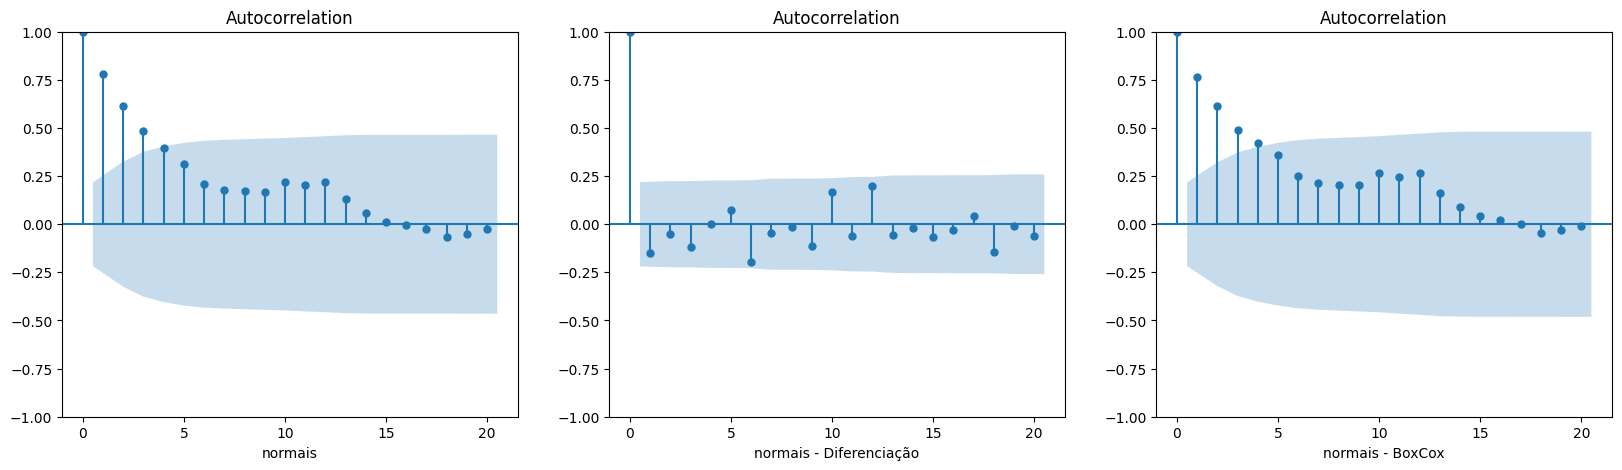

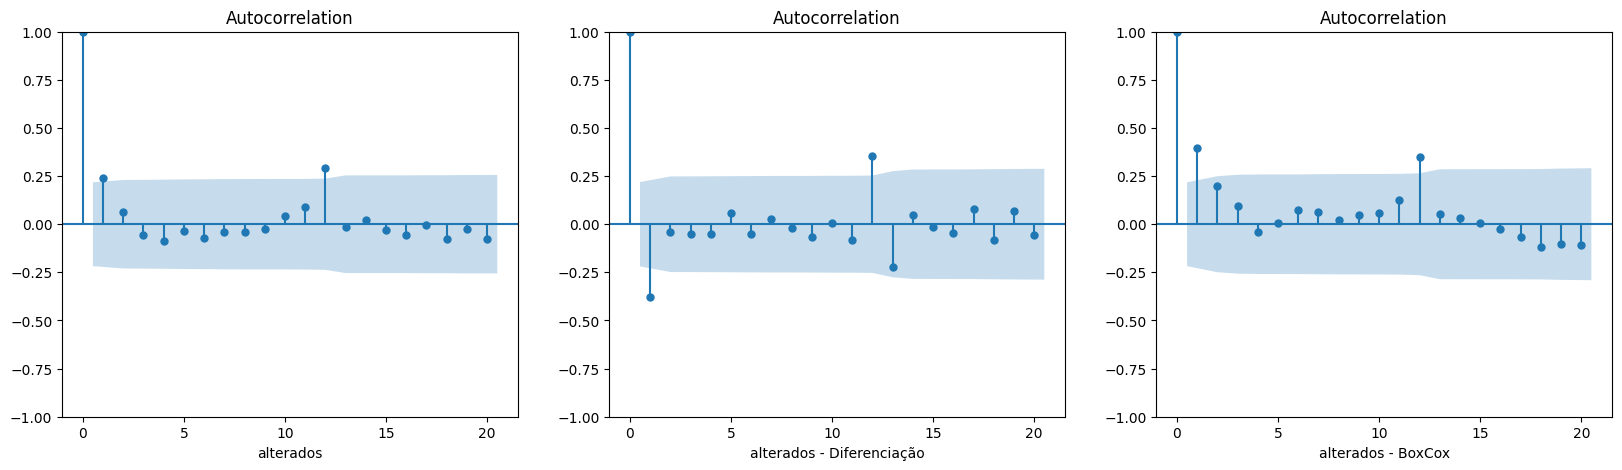

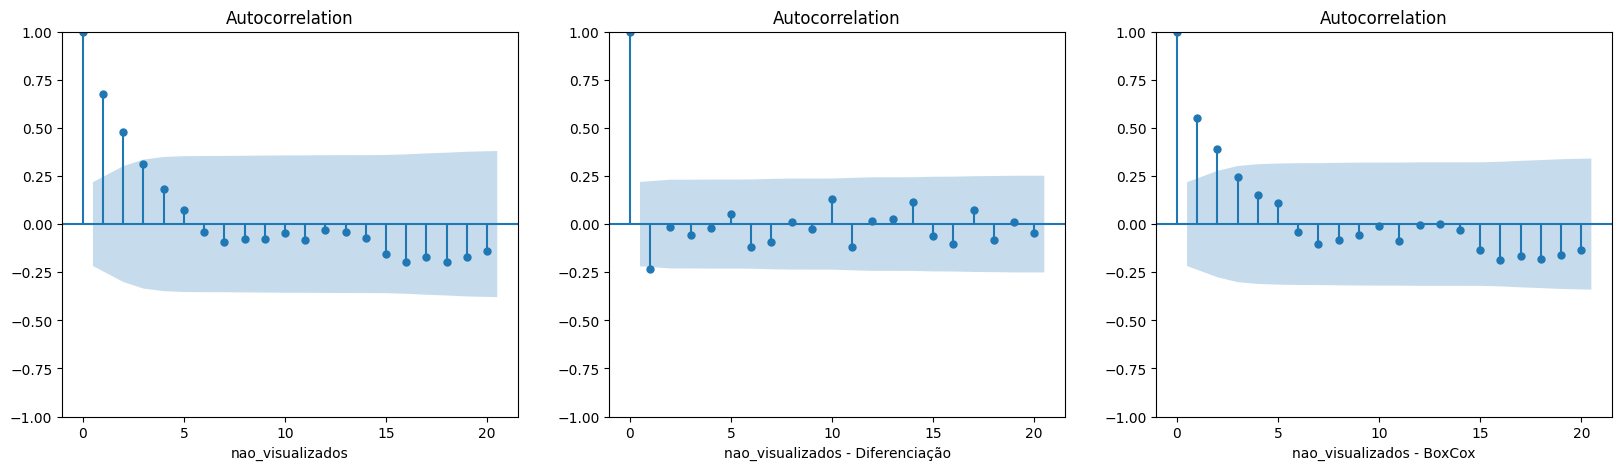

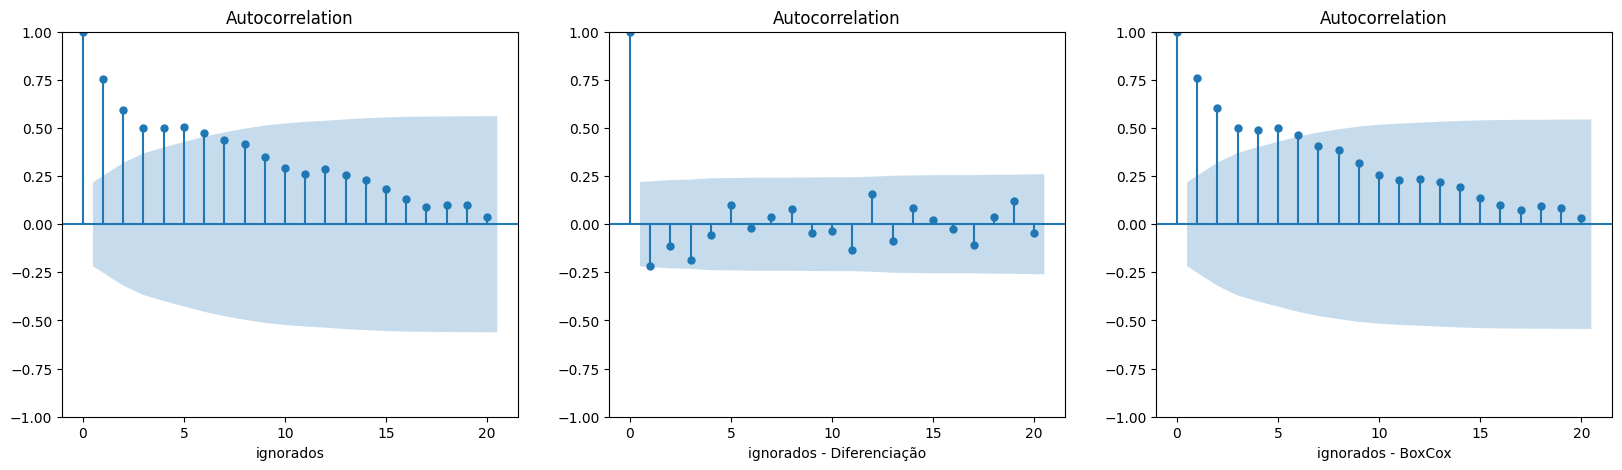

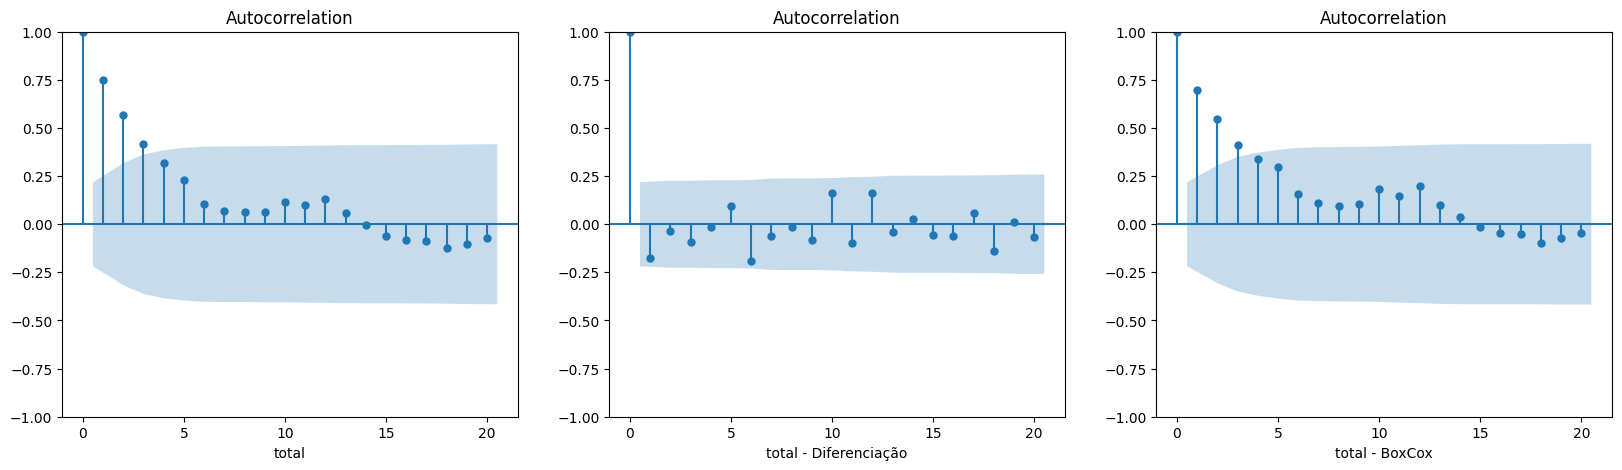

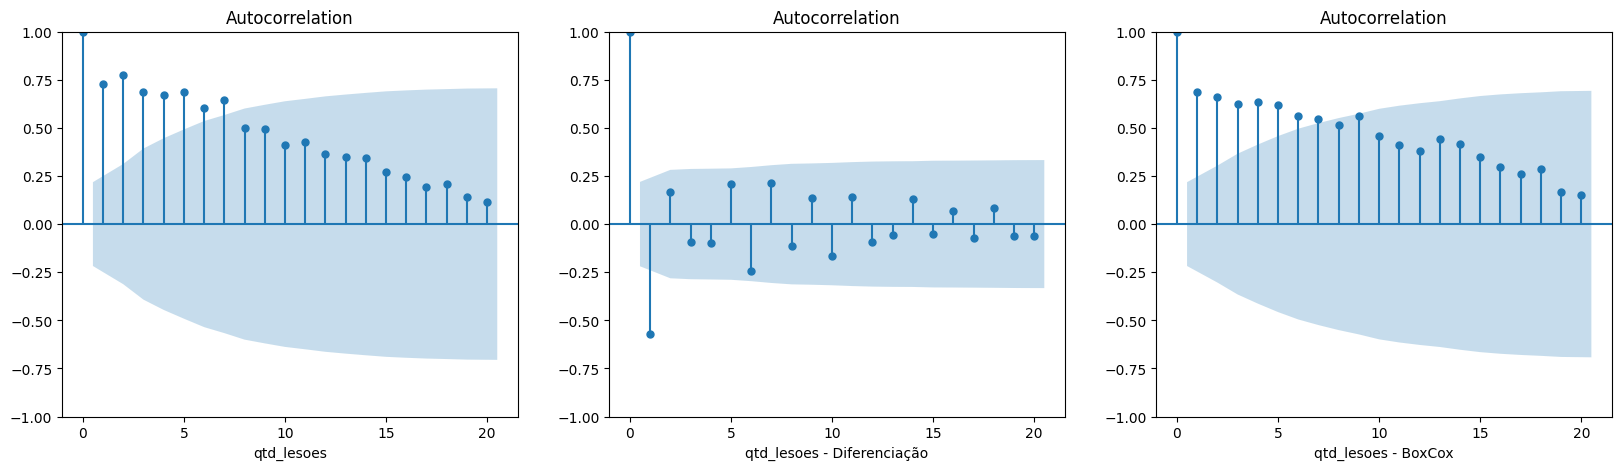

In [ ]:
# Gráfico de autocorrelação total:
for coluna in df_EDA_decomposicao.columns[0:6]:
  fig, axes = plt.subplots(1,3, figsize=(20,5))
  plot_acf(df_EDA_decomposicao[coluna], ax=axes[0]);
  plot_acf(df_EDA_decomposicao['diff_'+coluna].iloc[1:], ax=axes[1]);
  plot_acf(df_EDA_decomposicao['boxcox_'+coluna], ax=axes[2]);
  axes[0].set_xlabel(coluna);
  axes[1].set_xlabel(coluna + " - Diferenciação");
  axes[2].set_xlabel(coluna + " - BoxCox");

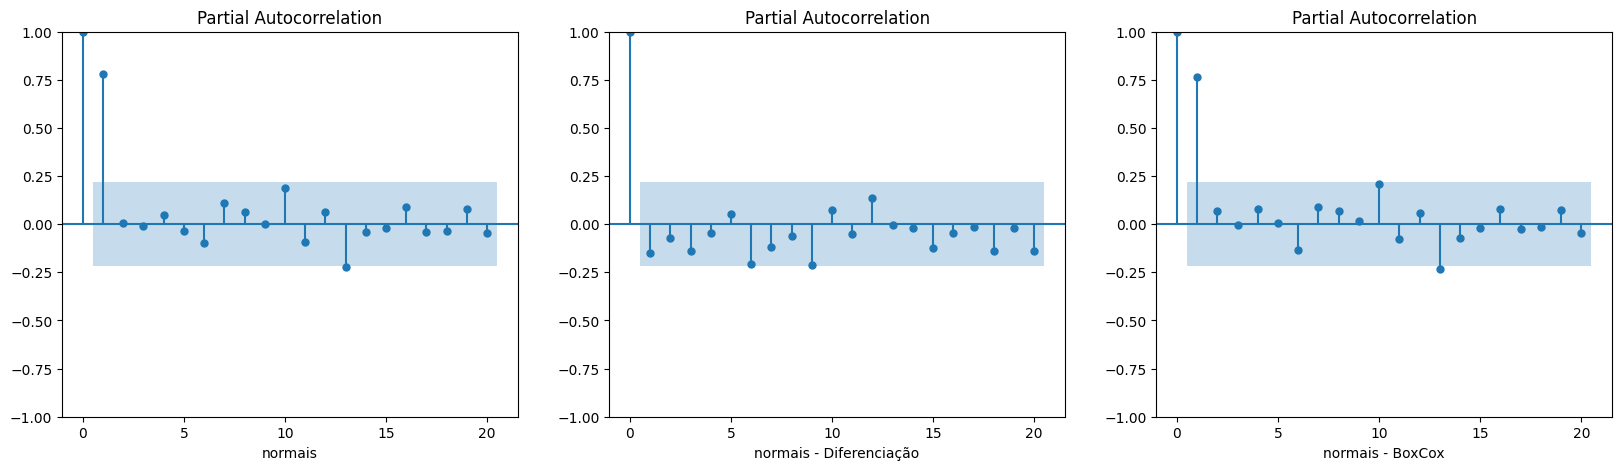

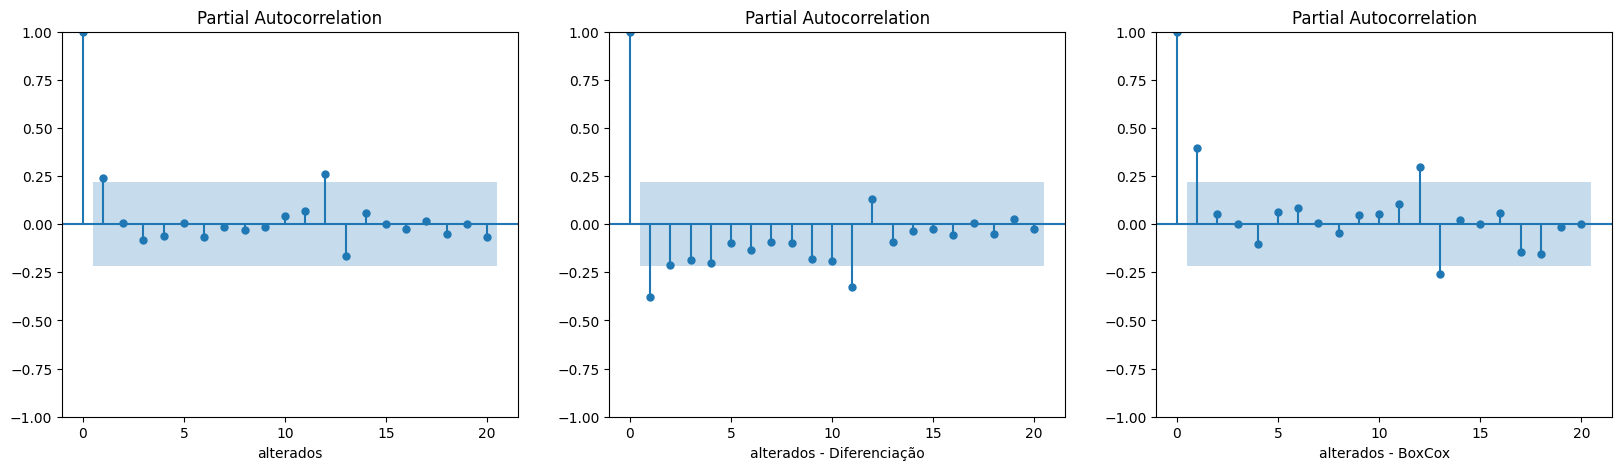

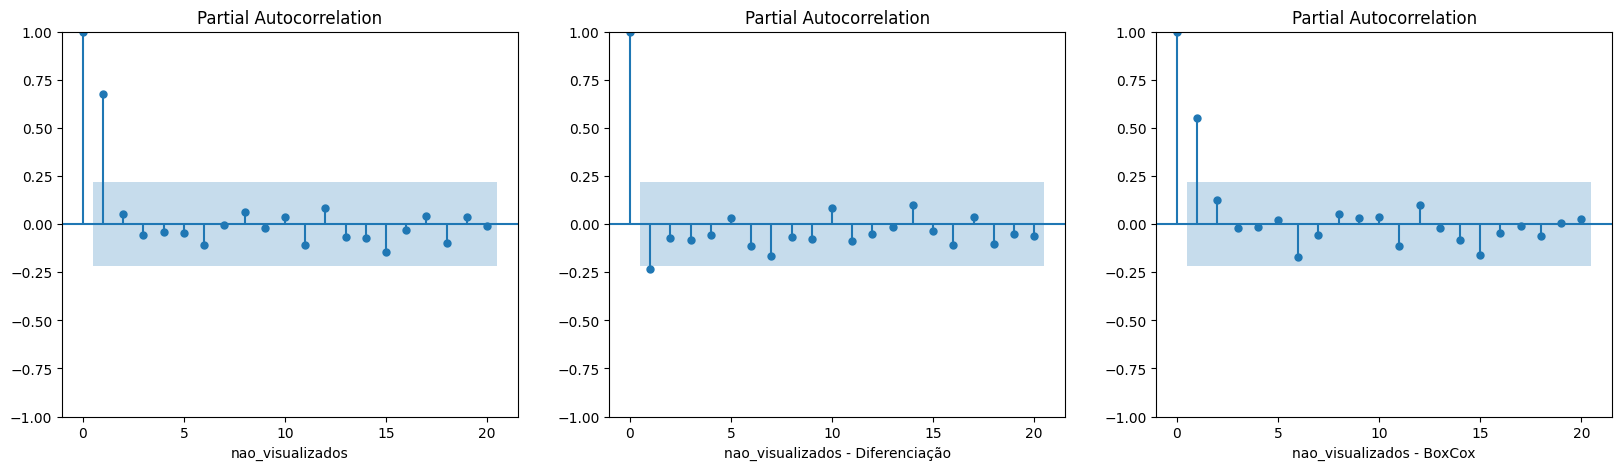

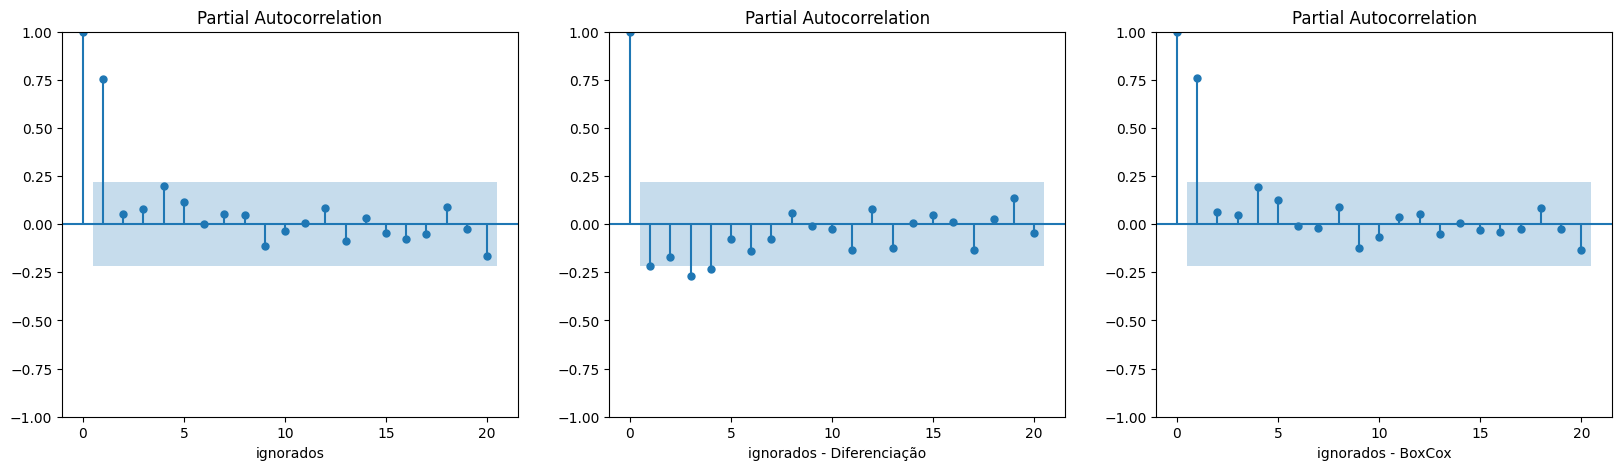

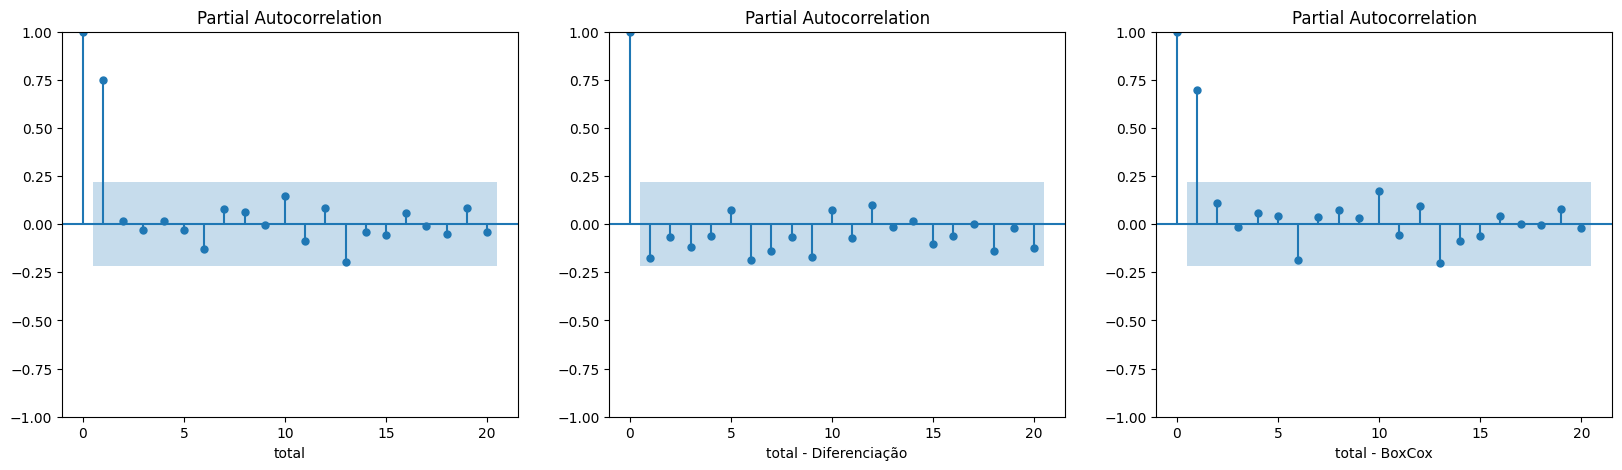

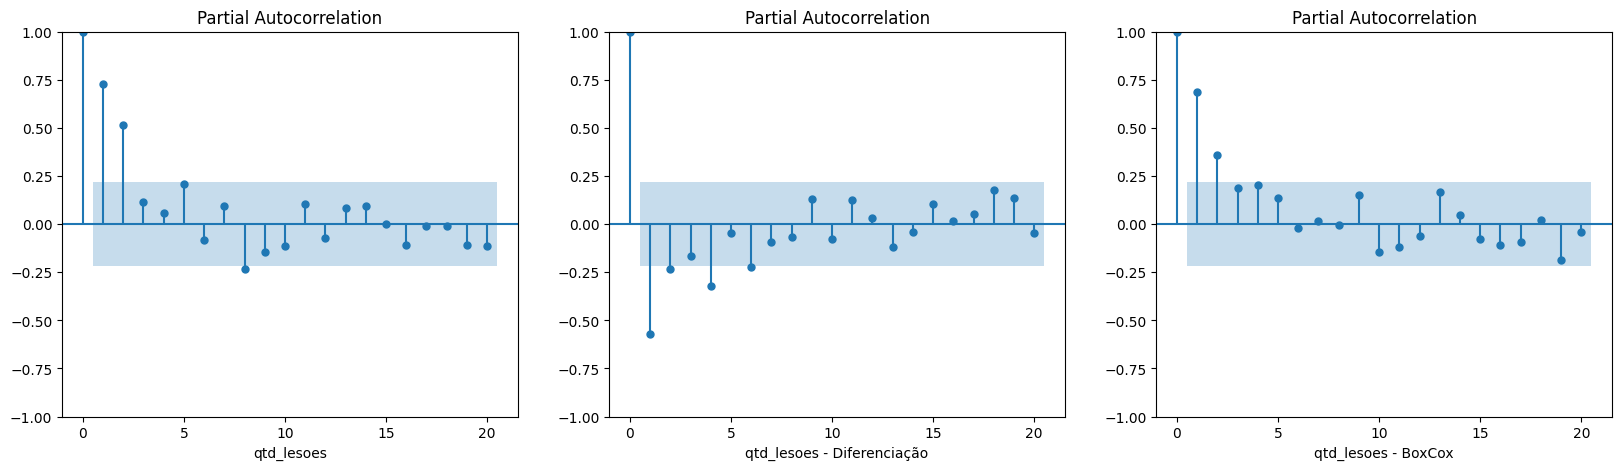

In [ ]:
# Gráfico de autocorrelação parcial:
for coluna in df_EDA_decomposicao.columns[0:6]:
  fig, axes = plt.subplots(1,3, figsize=(20,5))
  plot_pacf(df_EDA_decomposicao[coluna], ax=axes[0]);
  plot_pacf(df_EDA_decomposicao['diff_'+coluna].iloc[1:], ax=axes[1]);
  plot_pacf(df_EDA_decomposicao['boxcox_'+coluna], ax=axes[2]);
  axes[0].set_xlabel(coluna);
  axes[1].set_xlabel(coluna + " - Diferenciação");
  axes[2].set_xlabel(coluna + " - BoxCox");

## 3. Modelagem

O método de avaliação entre os modelos será a Raiz do Erro Médio Quadrático (RMSE em inglês), pois trabalha bem com grandes quantidades de dados, e penaliza mais os erros elevados.

### 3.1 Divisão em conjuntos de treino e teste

In [ ]:
# Separando em 80%|20%:
indice = int(len(df_EDA)*0.8)

df_EDA_treino = df_EDA.iloc[:indice, :]
df_EDA_treino = df_EDA_treino[['mes_ano','normais', 'alterados', 'nao_visualizados', 'ignorados', 'total', 'qtd_lesoes']]
df_EDA_teste = df_EDA.iloc[indice:, :]
df_EDA_teste = df_EDA_teste[['mes_ano','normais', 'alterados', 'nao_visualizados', 'ignorados', 'total', 'qtd_lesoes']]

print('Dataset treino:')
display(df_EDA_treino.head())
print('\n\n Dataset teste:')
display(df_EDA_teste.head())

Dataset treino:


,mes_ano,normais,alterados,nao_visualizados,ignorados,total,qtd_lesoes
0,2017-01-01,4398,331,2315,36,7080,0.0
1,2017-02-01,4343,119,2505,38,7005,0.0
2,2017-03-01,6336,191,3504,59,10090,1.0
3,2017-04-01,6005,57,3863,69,9994,3.0
4,2017-05-01,8458,13,5236,75,13782,3.0




 Dataset teste:


,mes_ano,normais,alterados,nao_visualizados,ignorados,total,qtd_lesoes
64,2022-05-01,19196,77,8833,212,28318,16.0
65,2022-06-01,12380,46,5967,183,18576,18.0
66,2022-07-01,16323,54,7477,282,24136,27.0
67,2022-08-01,18257,73,7615,300,26245,28.0
68,2022-09-01,18445,60,7197,222,25924,22.0


In [ ]:
# Vetor de pré-processamento:
preprocessamento = ['nenhum','diff','boxcox']

### 3.2 Comparando modelos

In [ ]:
# Dataframe de resultados:
resultados = pd.DataFrame(columns = ['grupo', 'preprocessamento','rmse'])

for coluna in df_EDA_treino.columns[1:]:
  for prep in preprocessamento:
    # Treino:
    treino = df_EDA_treino[['mes_ano',coluna]].copy()
    treino.columns = ['ds','y']

    # Transformação:
    if prep == 'nenhum':
        pass
    elif prep == 'diff':
        primeiro_valor = treino.y[0]
        treino.y = treino.y.diff()
        treino = treino.iloc[1:,:]    # Removendo NaN
    elif prep == 'boxcox':
        treino_box, best_lambda = stats.boxcox(treino.y+1)
        treino.y = treino_box

    # Rodando modelo:
    m = Prophet()
    m.fit(treino)

    # Calculando índices de início e término da previsão:
    vetor_indice = []
    for indice in range(1,len(df_EDA_teste)+1):
      vetor_indice.append(treino.iloc[-1,0] + pd.DateOffset(months=indice))
    vetor_indice = pd.DataFrame(vetor_indice, columns = ["ds"])

    # Gerar previsão:
    predicao = m.predict(vetor_indice);

    # Transformação inversa:
    if prep == 'nenhum':
        pass
    elif prep == 'diff':
        inv_diff = predicao.yhat.cumsum()
        inv_diff = inv_diff.fillna(0) + primeiro_valor
        predicao.yhat = inv_diff
    elif prep == 'boxcox':
        predicao.yhat = inv_boxcox(predicao.yhat, best_lambda)-1

    # Calculando RMSE:
    rmse_prophet = mean_squared_error(df_EDA_teste[coluna], predicao.yhat, squared = True)


    # # Gráficos com as séries:
    # fig = px.scatter(y = [df_EDA_teste[coluna], predicao.yhat],
    #                   title = 'Predição (vermelho) x Teste (azul) - ' + coluna + '(' + prep + ') - RMSE: ' + str(round(rmse_prophet,2)),
    #                  height = 300)
    # fig.show()
    # fig1 = m.plot(predicao, figsize=(9, 4))
    # fig1.show()

    # Inserindo valores na tabela resultados:
    linha = [coluna, prep, rmse_prophet]
    resultados = pd.DataFrame(np.insert(resultados.values, 0, values=linha, axis=0))

resultados.columns = ['grupo', 'preprocessamento','rmse']
resultados.sort_values(by = ['grupo','rmse'], ascending=True, inplace = True)
print()
display(resultados)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/f918_am6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/5jc39uec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10612', 'data', 'file=/tmp/tmps2xnyub3/f918_am6.json', 'init=/tmp/tmps2xnyub3/5jc39uec.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_modelf64segxn/prophet_model-20231214013731.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

,grupo,preprocessamento,rmse
12,alterados,boxcox,10416.905363
14,alterados,nenhum,21932.45679
13,alterados,diff,120803.351622
6,ignorados,boxcox,3453.180043
8,ignorados,nenhum,3522.53327
7,ignorados,diff,53590.344198
9,nao_visualizados,boxcox,2532125.899713
11,nao_visualizados,nenhum,3017673.162118
10,nao_visualizados,diff,37887452.848093
15,normais,boxcox,9816510.174346


### 3.3 Gerando previsões

In [ ]:
# Dataset com previsões:
previsoes = pd.DataFrame()

In [ ]:
# Calculando índices de início e término da previsão:
vetor_indice = []
for indice in range(1,12*2+4):
  vetor_indice.append(df_EDA.iloc[-1,0] + pd.DateOffset(months=indice))
vetor_indice = pd.DataFrame(vetor_indice, columns = ["ds"])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/fp8uw9bg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/k85ncvr8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40963', 'data', 'file=/tmp/tmps2xnyub3/fp8uw9bg.json', 'init=/tmp/tmps2xnyub3/k85ncvr8.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_modelu11mbw0p/prophet_model-20231214013737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2025-08-01,21339.037837,15827.134464,23921.685478,21338.782943,21339.279163,-1545.625452,-1545.625452,-1545.625452,-1545.625452,-1545.625452,-1545.625452,0.0,0.0,0.0,19793.412385
23,2025-09-01,21460.281473,15603.686277,24126.560009,21460.007688,21460.538940,-1705.917675,-1705.917675,-1705.917675,-1705.917675,-1705.917675,-1705.917675,0.0,0.0,0.0,19754.363798
24,2025-10-01,21577.614024,20440.836496,28430.184814,21577.322845,21577.892339,2928.418459,2928.418459,2928.418459,2928.418459,2928.418459,2928.418459,0.0,0.0,0.0,24506.032483
25,2025-11-01,21698.857660,20718.595733,28671.812751,21698.552460,21699.145776,2892.598476,2892.598476,2892.598476,2892.598476,2892.598476,2892.598476,0.0,0.0,0.0,24591.456136
26,2025-12-01,21816.190211,19589.814530,27394.827241,21815.864683,21816.504050,1618.991155,1618.991155,1618.991155,1618.991155,1618.991155,1618.991155,0.0,0.0,0.0,23435.181365


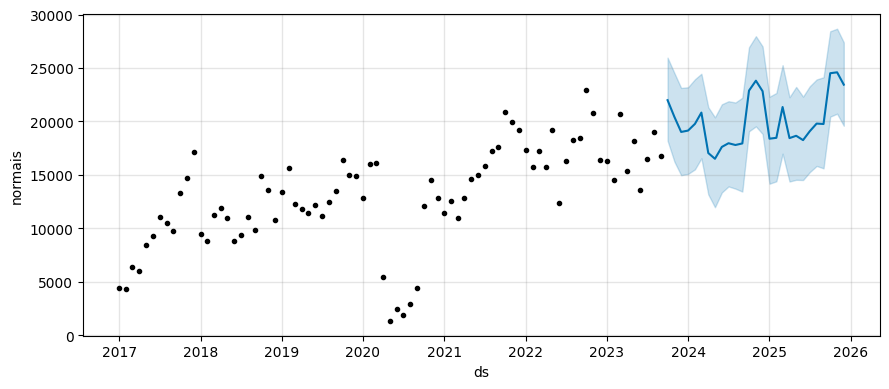

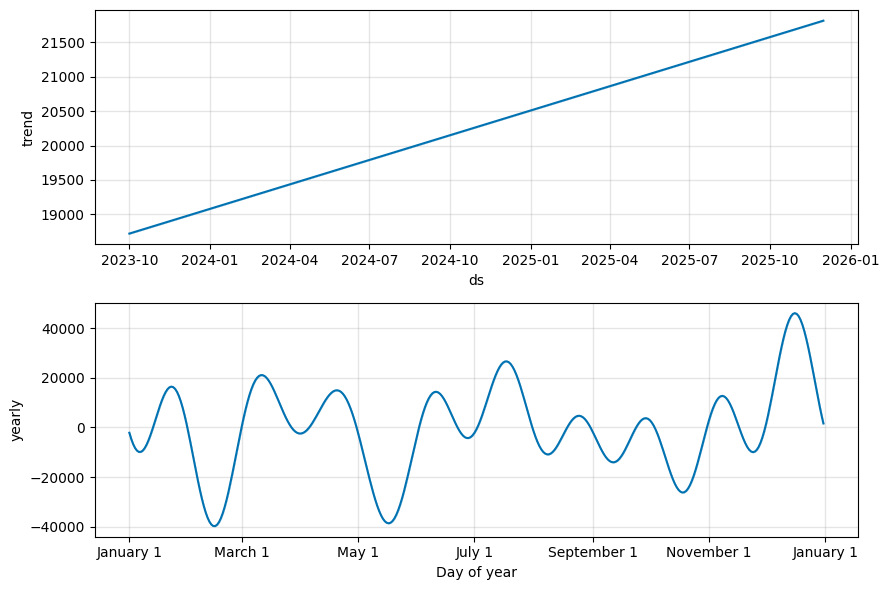

In [ ]:
# normais:
coluna = 'normais'
treino = df_EDA[['mes_ano',coluna]].copy()
treino.columns = ['ds','y']

# Rodando modelo:
m = Prophet()
m.fit(treino)

# Gerar previsão:
predicao = m.predict(vetor_indice)

# Tabela com resultados:
display(predicao.tail())

# Gráficos com as séries:
fig = m.plot(predicao, figsize=(9, 4), ylabel=coluna)
fig.show()

fig1 = m.plot_components(predicao)
fig1.show()

# Montando dataset para visão total
previsoes['mes_ano'] = predicao.ds
previsoes[coluna] = predicao.yhat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/syhnj4sw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/755_yft4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1194', 'data', 'file=/tmp/tmps2xnyub3/syhnj4sw.json', 'init=/tmp/tmps2xnyub3/755_yft4.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_model2xcbpxqy/prophet_model-20231214013738.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2025-08-01,143.927870,-59.256512,227.585450,140.036438,147.976692,-62.842196,-62.842196,-62.842196,-62.842196,-62.842196,-62.842196,0.0,0.0,0.0,81.085673
23,2025-09-01,144.608022,-53.253196,224.946493,140.442851,148.930414,-60.933024,-60.933024,-60.933024,-60.933024,-60.933024,-60.933024,0.0,0.0,0.0,83.674998
24,2025-10-01,145.266233,366.024835,651.201293,140.824085,149.749062,360.834512,360.834512,360.834512,360.834512,360.834512,360.834512,0.0,0.0,0.0,506.100745
25,2025-11-01,145.946385,101.306835,389.356826,141.258828,150.726830,102.688071,102.688071,102.688071,102.688071,102.688071,102.688071,0.0,0.0,0.0,248.634457
26,2025-12-01,146.604597,22.971423,323.656902,141.637531,151.661987,31.871434,31.871434,31.871434,31.871434,31.871434,31.871434,0.0,0.0,0.0,178.476031


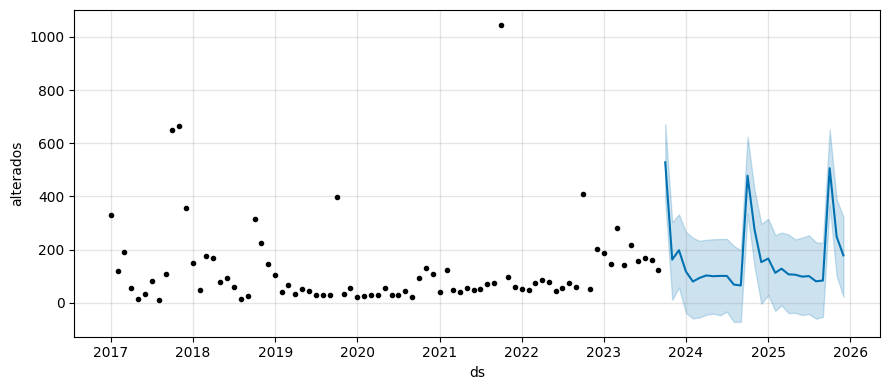

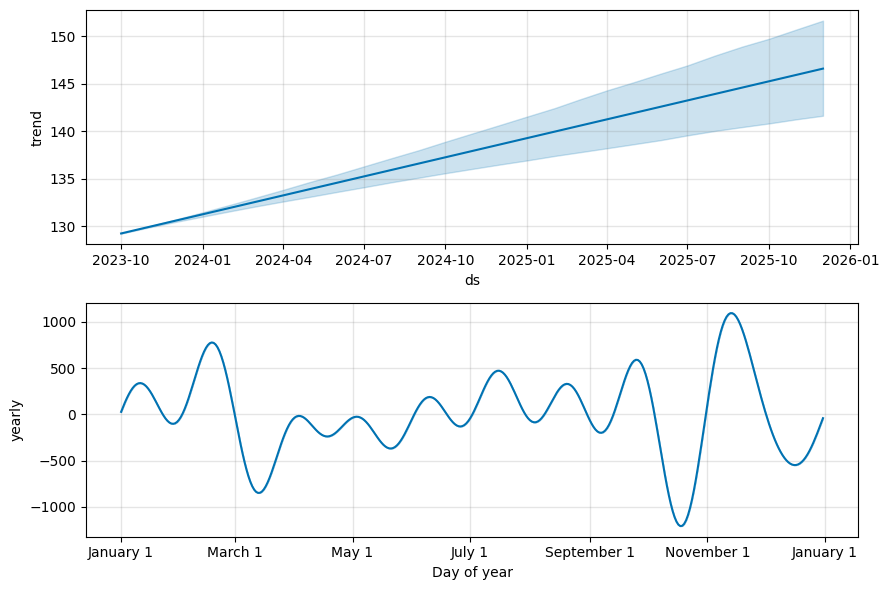

In [ ]:
# alterados:
coluna = 'alterados'
treino = df_EDA[['mes_ano',coluna]].copy()
treino.columns = ['ds','y']

# # Transformação Box-Cox:
# treino_box, best_lambda = stats.boxcox(treino.y+1)
# treino.y = treino_box
# primeiro_valor = treino.y[0]
# treino.y = treino.y.diff()
# treino = treino.iloc[1:,:]    # Removendo NaN


# Rodando modelo:
m = Prophet()
m.fit(treino)

# Gerar previsão:
predicao = m.predict(vetor_indice)

# # Transformação Inversa:
# predicao.yhat = inv_boxcox(predicao.yhat, best_lambda)-1
# inv_diff = predicao.yhat.cumsum()
# inv_diff = inv_diff.fillna(0) + primeiro_valor
# predicao.yhat = inv_diff

# Tabela com resultados:
display(predicao.tail())

# Gráficos com as séries:
fig = m.plot(predicao, figsize=(9, 4), ylabel=coluna)
fig.show()

fig1 = m.plot_components(predicao)
fig1.show()

# Montando dataset para visão total
previsoes['mes_ano'] = predicao.ds
previsoes[coluna] = predicao.yhat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/2sb4w9my.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/bf_hp4et.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22614', 'data', 'file=/tmp/tmps2xnyub3/2sb4w9my.json', 'init=/tmp/tmps2xnyub3/bf_hp4et.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_modeltmf03h1e/prophet_model-20231214013740.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2025-08-01,8892.753942,5857.002593,10523.165384,8892.749843,8892.758172,-695.538282,-695.538282,-695.538282,-695.538282,-695.538282,-695.538282,0.0,0.0,0.0,8197.215660
23,2025-09-01,8915.922127,5544.968969,10315.684595,8915.917701,8915.926660,-958.539719,-958.539719,-958.539719,-958.539719,-958.539719,-958.539719,0.0,0.0,0.0,7957.382408
24,2025-10-01,8938.342950,7407.157607,12218.075258,8938.338294,8938.347715,879.712315,879.712315,879.712315,879.712315,879.712315,879.712315,0.0,0.0,0.0,9818.055266
25,2025-11-01,8961.511135,7719.600511,12482.516853,8961.506212,8961.516113,1177.016732,1177.016732,1177.016732,1177.016732,1177.016732,1177.016732,0.0,0.0,0.0,10138.527867
26,2025-12-01,8983.931959,7549.688380,12323.544914,8983.926705,8983.937191,951.580564,951.580564,951.580564,951.580564,951.580564,951.580564,0.0,0.0,0.0,9935.512523


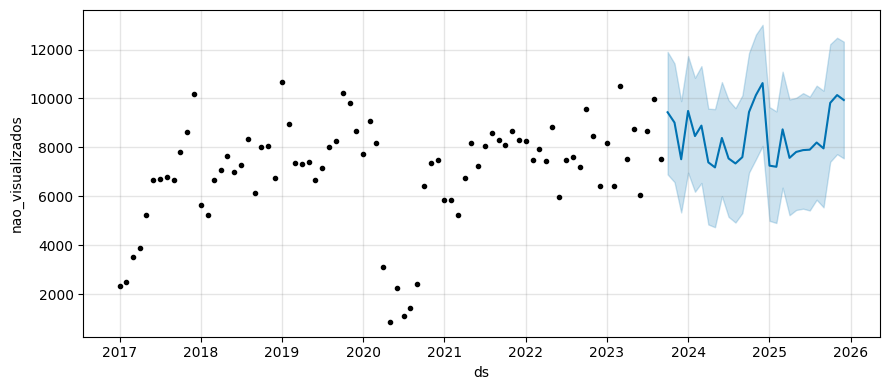

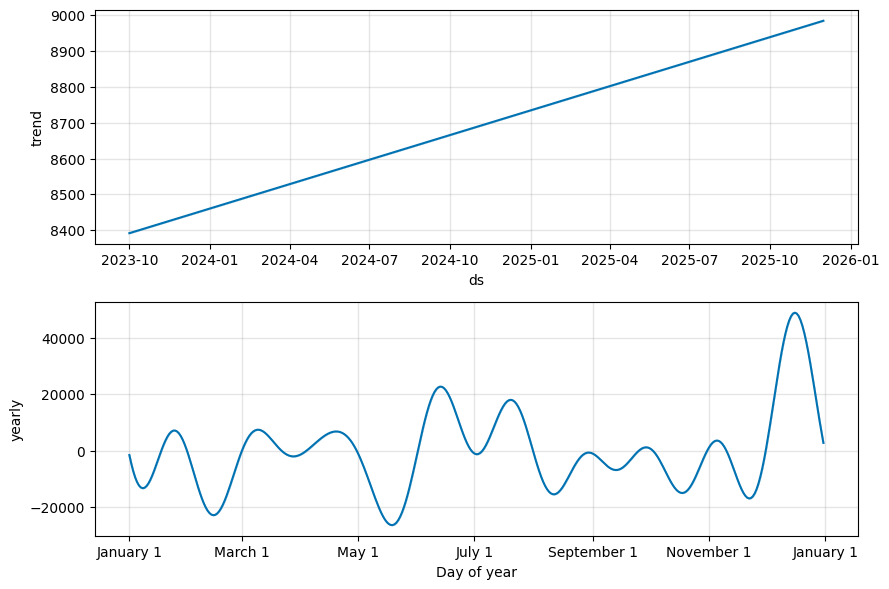

In [ ]:
# nao_visualizados:
coluna = 'nao_visualizados'
treino = df_EDA[['mes_ano',coluna]].copy()
treino.columns = ['ds','y']

# # Transformação Box-Cox:
# treino_box, best_lambda = stats.boxcox(treino.y+1)
# treino.y = treino_box
# primeiro_valor = treino.y[0]
# treino.y = treino.y.diff()
# treino = treino.iloc[1:,:]    # Removendo NaN


# Rodando modelo:
m = Prophet()
m.fit(treino)

# Gerar previsão:
predicao = m.predict(vetor_indice)

# # Transformação Inversa:
# predicao.yhat = inv_boxcox(predicao.yhat, best_lambda)-1
# inv_diff = predicao.yhat.cumsum()
# inv_diff = inv_diff.fillna(0) + primeiro_valor
# predicao.yhat = inv_diff

# Tabela com resultados:
display(predicao.tail())

# Gráficos com as séries:
fig = m.plot(predicao, figsize=(9, 4), ylabel=coluna)
fig.show()

fig1 = m.plot_components(predicao)
fig1.show()

# Montando dataset para visão total
previsoes['mes_ano'] = predicao.ds
previsoes[coluna] = predicao.yhat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/c2806w5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/pzwmq5zj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8805', 'data', 'file=/tmp/tmps2xnyub3/c2806w5k.json', 'init=/tmp/tmps2xnyub3/pzwmq5zj.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_model0k0sstsq/prophet_model-20231214013742.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2025-08-01,267.277254,247.408682,338.582852,267.262826,267.289767,23.614320,23.614320,23.614320,23.614320,23.614320,23.614320,0.0,0.0,0.0,290.891574
23,2025-09-01,269.330292,233.039173,327.380510,269.314573,269.343561,7.982442,7.982442,7.982442,7.982442,7.982442,7.982442,0.0,0.0,0.0,277.312734
24,2025-10-01,271.317103,206.141179,293.763203,271.300580,271.331233,-19.987182,-19.987182,-19.987182,-19.987182,-19.987182,-19.987182,0.0,0.0,0.0,251.329921
25,2025-11-01,273.370141,207.347634,297.824322,273.352484,273.385187,-20.025239,-20.025239,-20.025239,-20.025239,-20.025239,-20.025239,0.0,0.0,0.0,253.344902
26,2025-12-01,275.356952,208.974955,297.384245,275.338170,275.373095,-24.336695,-24.336695,-24.336695,-24.336695,-24.336695,-24.336695,0.0,0.0,0.0,251.020257


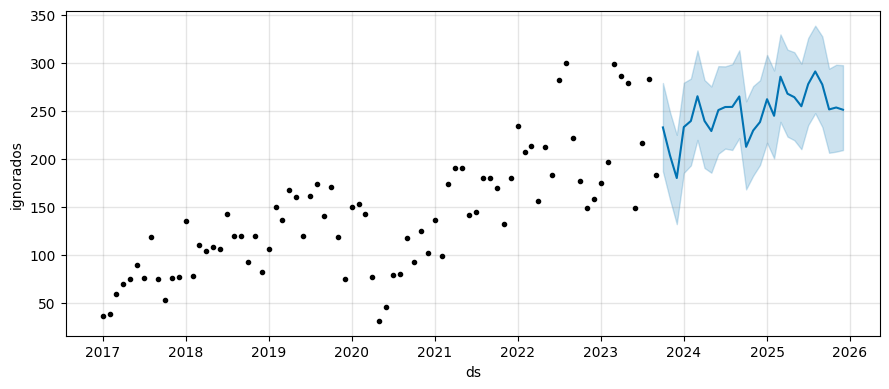

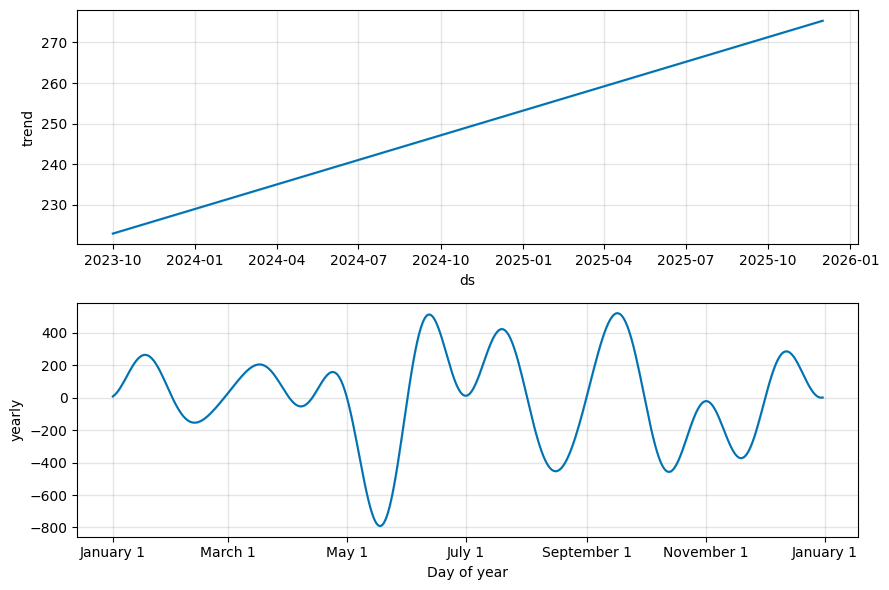

In [ ]:
# ignorados:
coluna = 'ignorados'
treino = df_EDA[['mes_ano',coluna]].copy()
treino.columns = ['ds','y']

# # Transformação Box-Cox:
# treino_box, best_lambda = stats.boxcox(treino.y+1)
# treino.y = treino_box
# primeiro_valor = treino.y[0]
# treino.y = treino.y.diff()
# treino = treino.iloc[1:,:]    # Removendo NaN


# Rodando modelo:
m = Prophet()
m.fit(treino)

# Gerar previsão:
predicao = m.predict(vetor_indice)

# # Transformação Inversa:
# predicao.yhat = inv_boxcox(predicao.yhat, best_lambda)-1
# inv_diff = predicao.yhat.cumsum()
# inv_diff = inv_diff.fillna(0) + primeiro_valor
# predicao.yhat = inv_diff

# Tabela com resultados:
display(predicao.tail())

# Gráficos com as séries:
fig = m.plot(predicao, figsize=(9, 4), ylabel=coluna)
fig.show()

fig1 = m.plot_components(predicao)
fig1.show()

# Montando dataset para visão total
previsoes['mes_ano'] = predicao.ds
previsoes[coluna] = predicao.yhat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/fow4p47_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/zjnhzwbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64081', 'data', 'file=/tmp/tmps2xnyub3/fow4p47_.json', 'init=/tmp/tmps2xnyub3/zjnhzwbb.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_model5e1g4hhh/prophet_model-20231214013744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2025-08-01,30654.416510,21834.491981,34360.131768,30653.613574,30655.281014,-2268.166478,-2268.166478,-2268.166478,-2268.166478,-2268.166478,-2268.166478,0.0,0.0,0.0,28386.250032
23,2025-09-01,30801.635412,21884.842675,34456.253274,30800.787362,30802.563641,-2708.550144,-2708.550144,-2708.550144,-2708.550144,-2708.550144,-2708.550144,0.0,0.0,0.0,28093.085268
24,2025-10-01,30944.105318,28425.173947,41315.053034,30943.214446,30945.103098,4153.638630,4153.638630,4153.638630,4153.638630,4153.638630,4153.638630,0.0,0.0,0.0,35097.743948
25,2025-11-01,31091.324221,28810.536118,41686.716037,31090.373468,31092.376653,4151.564987,4151.564987,4151.564987,4151.564987,4151.564987,4151.564987,0.0,0.0,0.0,35242.889208
26,2025-12-01,31233.794126,27485.665082,40357.684551,31232.778370,31234.903092,2577.041715,2577.041715,2577.041715,2577.041715,2577.041715,2577.041715,0.0,0.0,0.0,33810.835841


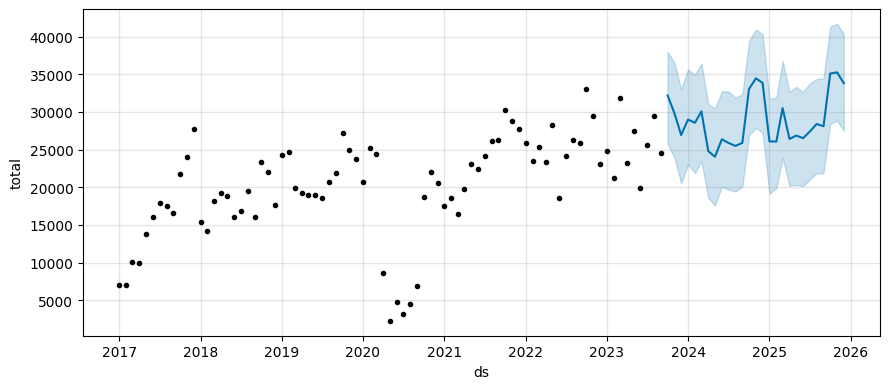

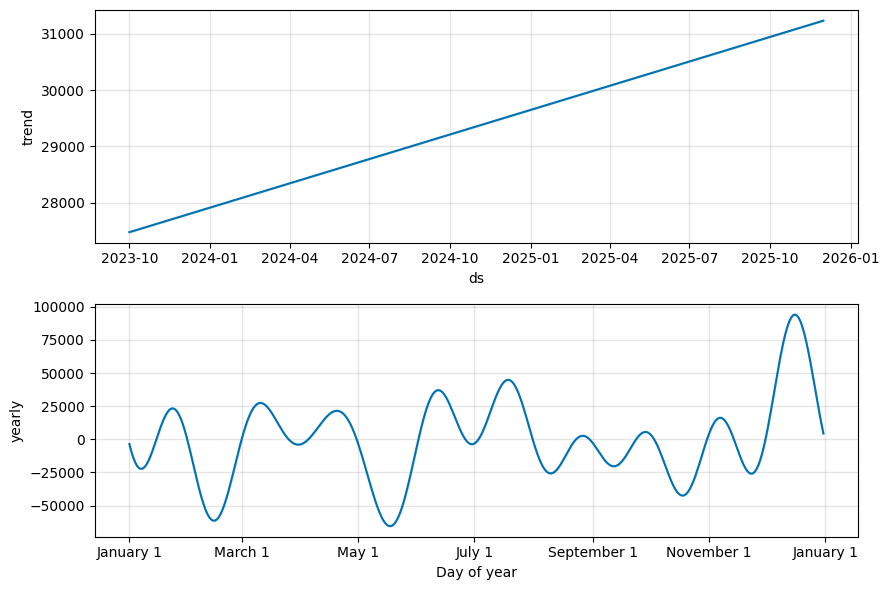

In [ ]:
# total:
coluna = 'total'
treino = df_EDA[['mes_ano',coluna]].copy()
treino.columns = ['ds','y']

# # Transformação Box-Cox:
# treino_box, best_lambda = stats.boxcox(treino.y+1)
# treino.y = treino_box
# primeiro_valor = treino.y[0]
# treino.y = treino.y.diff()
# treino = treino.iloc[1:,:]    # Removendo NaN


# Rodando modelo:
m = Prophet()
m.fit(treino)

# Gerar previsão:
predicao = m.predict(vetor_indice)

# # Transformação Inversa:
# predicao.yhat = inv_boxcox(predicao.yhat, best_lambda)-1
# inv_diff = predicao.yhat.cumsum()
# inv_diff = inv_diff.fillna(0) + primeiro_valor
# predicao.yhat = inv_diff

# Tabela com resultados:
display(predicao.tail())

# Gráficos com as séries:
fig = m.plot(predicao, figsize=(9, 4), ylabel=coluna)
fig.show()

fig1 = m.plot_components(predicao)
fig1.show()

# Montando dataset para visão total
previsoes['mes_ano'] = predicao.ds
previsoes[coluna] = predicao.yhat

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/tohwvl4b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmps2xnyub3/xooy6ra1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66472', 'data', 'file=/tmp/tmps2xnyub3/tohwvl4b.json', 'init=/tmp/tmps2xnyub3/xooy6ra1.json', 'output', 'file=/tmp/tmps2xnyub3/prophet_modellci3too2/prophet_model-20231214013746.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:37:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:37:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
22,2025-08-01,43.065121,36.934648,47.984845,41.774379,44.096154,-0.941670,-0.941670,-0.941670,-0.941670,-0.941670,-0.941670,0.0,0.0,0.0,42.123452
23,2025-09-01,43.700258,41.512185,51.934347,42.347438,44.809357,3.111697,3.111697,3.111697,3.111697,3.111697,3.111697,0.0,0.0,0.0,46.811955
24,2025-10-01,44.314907,36.404487,47.370985,42.887039,45.486538,-2.494042,-2.494042,-2.494042,-2.494042,-2.494042,-2.494042,0.0,0.0,0.0,41.820864
25,2025-11-01,44.950043,37.708575,48.740517,43.426597,46.218152,-1.674121,-1.674121,-1.674121,-1.674121,-1.674121,-1.674121,0.0,0.0,0.0,43.275922
26,2025-12-01,45.564692,40.187167,51.629416,43.927047,46.907608,0.660298,0.660298,0.660298,0.660298,0.660298,0.660298,0.0,0.0,0.0,46.224990


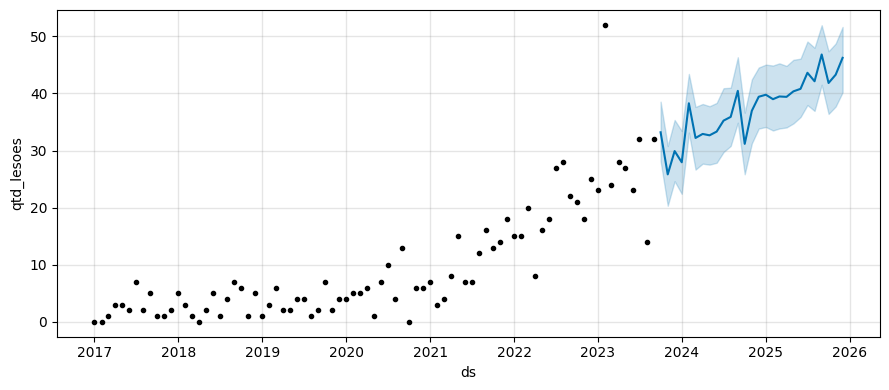

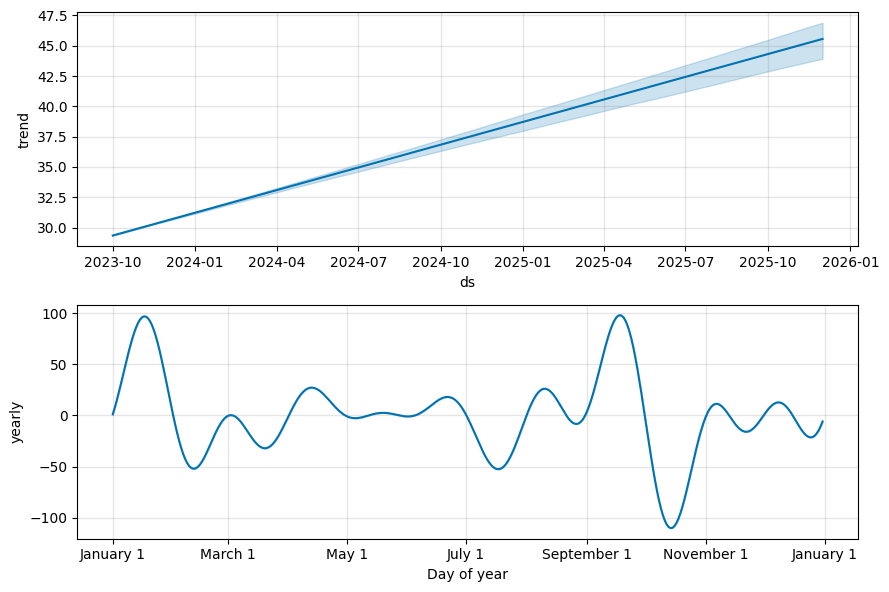

In [ ]:
# qtd_lesoes:
coluna = 'qtd_lesoes'
treino = df_EDA[['mes_ano',coluna]].copy()
treino.columns = ['ds','y']

# # Transformação Box-Cox:
# treino_box, best_lambda = stats.boxcox(treino.y+1)
# treino.y = treino_box
# primeiro_valor = treino.y[0]
# treino.y = treino.y.diff()
# treino = treino.iloc[1:,:]    # Removendo NaN


# Rodando modelo:
m = Prophet()
m.fit(treino)

# Gerar previsão:
predicao = m.predict(vetor_indice)

# # Transformação Inversa:
# predicao.yhat = inv_boxcox(predicao.yhat, best_lambda)-1
# inv_diff = predicao.yhat.cumsum()
# inv_diff = inv_diff.fillna(0) + primeiro_valor
# predicao.yhat = inv_diff

# Tabela com resultados:
display(predicao.tail())

# Gráficos com as séries:
fig = m.plot(predicao, figsize=(9, 4), ylabel=coluna)
fig.show()

fig1 = m.plot_components(predicao)
fig1.show()

# Montando dataset para visão total
previsoes['mes_ano'] = predicao.ds
previsoes[coluna] = predicao.yhat

In [ ]:
# Comparando previsão do consumo total com soma das previsões dos consumos:
previsoes['soma_previsoes'] = previsoes.normais + \
                                          previsoes.alterados + \
                                          previsoes.nao_visualizados + \
                                          previsoes.ignorados

# Gerando gráfico:
px.line(previsoes,
        y=['total','soma_previsoes'],
        x='mes_ano',
        title = 'Comparação entre Previsão do Total de Exames e Soma das Previsões dos Exames por resultados')

In [ ]:
# Gerando totais de consumo por ano:
previsoes['ano'] = previsoes.mes_ano.dt.year
df_resumo = pd.pivot_table(previsoes, index = 'ano', aggfunc='sum')
df_resumo

,alterados,ignorados,nao_visualizados,normais,qtd_lesoes,soma_previsoes,total
ano,,,,,,,
2023,888.894347,615.975150,25962.834201,61401.748372,88.912098,88869.452070,88922.800167
2024,1736.922676,2908.666097,102486.609086,234056.322960,416.387326,341188.520819,341349.476804
2025,1917.919334,3180.170632,100413.276765,244668.474082,502.630210,350179.840813,350430.427103


## 4. Proporcionalização


### 4.1 Região

In [ ]:
# Quantidade de exames:
df_exames_cidades.head(2)

,municipio,data,qtd_exames,CD_GEOCODI,cod_rgi,nome_rgint,ano
0,ABAIRA,2017-01-01,0,2900108,290013,Vitória da Conquista,2017
1,ABARE,2017-01-01,0,2900207,290024,Paulo Afonso,2017


In [ ]:
# Quantidade de exames por data e macrorregião:
df_aux = pd.pivot_table(df_exames_cidades,index='data',columns='nome_rgint',values='qtd_exames', aggfunc='sum').reset_index()
df_aux

nome_rgint,data,Barreiras,Feira de Santana,Guanambi,Ilhéus – Itabuna,Irecê,Juazeiro,Paulo Afonso,Salvador,Santo Antônio de Jesus,Vitória da Conquista
0,2017-01-01,263,2838,138,723,166,533,340,1476,113,490
1,2017-02-01,294,1707,638,616,130,415,625,1801,321,458
2,2017-03-01,663,2273,442,961,75,648,834,2562,515,1117
3,2017-04-01,361,2308,367,838,194,742,979,2772,457,976
4,2017-05-01,398,2513,2361,1116,158,1437,773,3485,325,1216
...,...,...,...,...,...,...,...,...,...,...,...
76,2023-05-01,651,3235,663,10047,116,2582,1586,5395,1002,2135
77,2023-06-01,552,2353,804,3152,108,2033,521,3351,1155,5888
78,2023-07-01,622,2272,3784,1460,109,1955,881,4646,983,8851
79,2023-08-01,784,2966,2268,1340,115,1684,648,6657,1103,11897


In [ ]:
# Medianas das quantidades de exames:
medianas = []
for col in df_aux.columns[1:]:
  print(f'{col} - {df_aux[col].median()}')
  medianas.append(df_aux[col].median())

Barreiras - 438.0
Feira de Santana - 2747.0
Guanambi - 793.0
Ilhéus – Itabuna - 1438.0
Irecê - 294.0
Juazeiro - 1378.0
Paulo Afonso - 807.0
Salvador - 4938.0
Santo Antônio de Jesus - 857.0
Vitória da Conquista - 1474.0


In [ ]:
# Medianas e porcentagens das quantidades de exames:
df_aux2 = pd.DataFrame()
df_aux2['regioes'] = df_aux.columns[1:]
df_aux2['medianas'] = medianas
df_aux2['porcentagem'] = df_aux2['medianas'] / df_aux2['medianas'].sum()
df_aux2

,regioes,medianas,porcentagem
0,Barreiras,438.0,0.028884
1,Feira de Santana,2747.0,0.181153
2,Guanambi,793.0,0.052295
3,Ilhéus – Itabuna,1438.0,0.094830
4,Irecê,294.0,0.019388
5,Juazeiro,1378.0,0.090873
6,Paulo Afonso,807.0,0.053218
7,Salvador,4938.0,0.325640
8,Santo Antônio de Jesus,857.0,0.056515
9,Vitória da Conquista,1474.0,0.097204


In [ ]:
# Quantidade prevista de exames por região:
df_resumo_exames = df_resumo[['total']].copy()
for regiao in df_aux2.regioes:
  df_resumo_exames[regiao] = (df_resumo_exames.total * df_aux2.loc[df_aux2.regioes == regiao, 'porcentagem'].iloc[0]).astype('int')
df_resumo_exames

,total,Barreiras,Feira de Santana,Guanambi,Ilhéus – Itabuna,Irecê,Juazeiro,Paulo Afonso,Salvador,Santo Antônio de Jesus,Vitória da Conquista
ano,,,,,,,,,,,
2023,88922.800167,2568,16108,4650,8432,1724,8080,4732,28956,5025,8643
2024,341349.476804,9859,61836,17850,32370,6618,31019,18165,111156,19291,33180
2025,350430.427103,10121,63481,18325,33231,6794,31844,18649,114114,19804,34063


In [ ]:
# Quantidade de lesões previstas por região:
df_resumo_lesoes = df_resumo[['qtd_lesoes']].copy()
for regiao in df_aux2.regioes:
  df_resumo_lesoes[regiao] = (df_resumo_lesoes.qtd_lesoes * df_aux2.loc[df_aux2.regioes == regiao, 'porcentagem'].iloc[0]).astype('int')
df_resumo_lesoes

,qtd_lesoes,Barreiras,Feira de Santana,Guanambi,Ilhéus – Itabuna,Irecê,Juazeiro,Paulo Afonso,Salvador,Santo Antônio de Jesus,Vitória da Conquista
ano,,,,,,,,,,,
2023,88.912098,2,16,4,8,1,8,4,28,5,8
2024,416.387326,12,75,21,39,8,37,22,135,23,40
2025,502.630210,14,91,26,47,9,45,26,163,28,48


### Cidade

In [ ]:
df_aux = pd.pivot_table(df_exames_cidades,index='data',columns='CD_GEOCODI',values='qtd_exames', aggfunc='sum').reset_index()
df_aux

CD_GEOCODI,data,2900108,2900207,2900306,2900355,2900405,2900504,2900603,2900702,2900801,...,2933109,2933158,2933174,2933208,2933257,2933307,2933406,2933455,2933505,2933604
0,2017-01-01,0,0,1,0,1,0,1,5,0,...,1,0,0,4,0,1,0,0,0,1
1,2017-02-01,0,0,0,0,0,0,1,6,0,...,0,1,1,2,0,0,1,1,1,0
2,2017-03-01,0,0,0,32,6,113,1,5,0,...,0,22,2,17,0,3,0,1,1,0
3,2017-04-01,0,1,0,114,9,353,0,2,2,...,13,0,7,14,0,2,0,1,0,3
4,2017-05-01,0,7,1,26,12,3,1,5,1,...,1,26,0,15,2,5,0,0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2023-05-01,0,34,6,14,8,11,2,49,17,...,10,7,6,32,14,434,1,11,4,2
77,2023-06-01,0,4,4,4,42,4,5,17,18,...,2,10,3,15,13,292,0,2,6,1
78,2023-07-01,0,3,6,13,38,10,4,19,17,...,0,3,9,14,5,263,0,6,5,2
79,2023-08-01,0,2,19,12,52,638,2,155,23,...,8,9,12,27,11,2258,2,6,2,4


In [ ]:
medianas = []
for col in df_aux.columns[1:]:
  print(f'{col} - {df_aux[col].median()}')
  medianas.append(df_aux[col].median())

2900108 - 0.0
2900207 - 2.0
2900306 - 5.0
2900355 - 13.0
2900405 - 11.0
2900504 - 2.0
2900603 - 2.0
2900702 - 52.0
2900801 - 4.0
2900900 - 4.0
2901007 - 15.0
2901106 - 26.0
2901155 - 3.0
2901205 - 2.0
2901304 - 1.0
2901353 - 15.0
2901403 - 7.0
2901502 - 14.0
2901601 - 11.0
2901700 - 16.0
2901809 - 21.0
2901908 - 5.0
2901957 - 3.0
2902005 - 8.0
2902054 - 2.0
2902104 - 36.0
2902203 - 3.0
2902252 - 2.0
2902302 - 5.0
2902401 - 3.0
2902500 - 4.0
2902609 - 7.0
2902658 - 21.0
2902708 - 3.0
2902807 - 93.0
2902906 - 3.0
2903003 - 2.0
2903102 - 2.0
2903201 - 233.0
2903235 - 1.0
2903276 - 19.0
2903300 - 2.0
2903409 - 3.0
2903508 - 4.0
2903607 - 4.0
2903706 - 5.0
2903805 - 2.0
2903904 - 5.0
2903953 - 3.0
2904001 - 1.0
2904050 - 1.0
2904100 - 14.0
2904209 - 5.0
2904308 - 5.0
2904407 - 3.0
2904506 - 3.0
2904605 - 205.0
2904704 - 7.0
2904753 - 1.0
2904803 - 0.0
2904852 - 10.0
2904902 - 22.0
2905008 - 10.0
2905107 - 5.0
2905156 - 1.0
2905206 - 22.0
2905305 - 1.0
2905404 - 4.0
2905503 - 2.0
2905602 - 4

In [ ]:
df_aux2 = pd.DataFrame()
df_aux2['cidades'] = df_aux.columns[1:]
df_aux2['medianas'] = medianas
df_aux2['porcentagem'] = df_aux2['medianas'] / df_aux2['medianas'].sum()
df_aux2

,cidades,medianas,porcentagem
0,2900108,0.0,0.000000
1,2900207,2.0,0.000168
2,2900306,5.0,0.000419
3,2900355,13.0,0.001089
4,2900405,11.0,0.000922
...,...,...,...
412,2933307,50.0,0.004189
413,2933406,0.0,0.000000
414,2933455,4.0,0.000335
415,2933505,4.0,0.000335


In [ ]:
# Quantidade de exames previstos por cidade:
df_resumo_exames = df_resumo[['total']].copy()
for cidade in df_aux2.cidades:
  df_resumo_exames[cidade] = (df_resumo_exames.total * df_aux2.loc[df_aux2.cidades == cidade, 'porcentagem'].iloc[0]).astype('int')
df_resumo_exames

,total,2900108,2900207,2900306,2900355,2900405,2900504,2900603,2900702,2900801,...,2933109,2933158,2933174,2933208,2933257,2933307,2933406,2933455,2933505,2933604
ano,,,,,,,,,,,,,,,,,,,,,
2023,88922.800167,0,14,37,96,81,14,14,387,29,...,37,67,52,96,14,372,0,29,29,29
2024,341349.476804,0,57,142,371,314,57,57,1487,114,...,142,257,200,371,57,1429,0,114,114,114
2025,350430.427103,0,58,146,381,322,58,58,1526,117,...,146,264,205,381,58,1467,0,117,117,117


In [ ]:
# Quantidade de lesões previstas por cidade:
df_resumo_lesoes = df_resumo[['qtd_lesoes']].copy()
for cidade in df_aux2.cidades:
  df_resumo_lesoes[cidade] = (df_resumo_lesoes.qtd_lesoes * df_aux2.loc[df_aux2.cidades == cidade, 'porcentagem'].iloc[0]).astype('int')
df_resumo_lesoes

,qtd_lesoes,2900108,2900207,2900306,2900355,2900405,2900504,2900603,2900702,2900801,...,2933109,2933158,2933174,2933208,2933257,2933307,2933406,2933455,2933505,2933604
ano,,,,,,,,,,,,,,,,,,,,,
2023,88.912098,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024,416.387326,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2025,502.630210,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,2,0,0,0,0


In [ ]:
df_previsoes_vyr = df_resumo_lesoes.iloc[:,1:].T
df_previsoes_vyr = df_previsoes_vyr.reset_index()
df_previsoes_vyr.columns = ['COD IBGE', 'Lesoes 2023', 'Lesoes 2024', 'Lesoes 2025']
df_previsoes_vyr.to_excel('VYR_Lesoes.xlsx', index = False)
df_previsoes_vyr

,COD IBGE,Lesoes 2023,Lesoes 2024,Lesoes 2025
0,2900108,0,0,0
1,2900207,0,0,0
2,2900306,0,0,0
3,2900355,0,0,0
4,2900405,0,0,0
...,...,...,...,...
412,2933307,0,1,2
413,2933406,0,0,0
414,2933455,0,0,0
415,2933505,0,0,0


In [ ]:
df_previsoes_vyr = df_resumo_exames.iloc[:,1:].T
df_previsoes_vyr = df_previsoes_vyr.reset_index()
df_previsoes_vyr.columns = ['COD IBGE', 'Exames 2023', 'Exames 2024', 'Exames 2025']
df_previsoes_vyr.to_excel('VYR_Exames.xlsx', index = False)
df_previsoes_vyr

,COD IBGE,Exames 2023,Exames 2024,Exames 2025
0,2900108,0,0,0
1,2900207,14,57,58
2,2900306,37,142,146
3,2900355,96,371,381
4,2900405,81,314,322
...,...,...,...,...
412,2933307,372,1429,1467
413,2933406,0,0,0
414,2933455,29,114,117
415,2933505,29,114,117
